In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFont, ImageDraw
from scipy.stats import norm
import numpy as np
import random
from string import ascii_letters, digits

In [ ]:
!unzip preprocessed_images.zip
!unzip fonts.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/preprocessed_images/._zj94bhi2.png  
  inflating: preprocessed_images/2hql5.png  
  inflating: __MACOSX/preprocessed_images/._2hql5.png  
  inflating: preprocessed_images/5vwzw.png  
  inflating: __MACOSX/preprocessed_images/._5vwzw.png  
  inflating: preprocessed_images/izrqif5.png  
  inflating: __MACOSX/preprocessed_images/._izrqif5.png  
  inflating: preprocessed_images/226fxf.png  
  inflating: __MACOSX/preprocessed_images/._226fxf.png  
  inflating: preprocessed_images/cnsb.png  
  inflating: __MACOSX/preprocessed_images/._cnsb.png  
  inflating: preprocessed_images/1filptv1.png  
  inflating: __MACOSX/preprocessed_images/._1filptv1.png  
  inflating: preprocessed_images/j9mv7.png  
  inflating: __MACOSX/preprocessed_images/._j9mv7.png  
  inflating: preprocessed_images/o6vs9u.png  
  inflating: __MACOSX/preprocessed_images/._o6vs9u.png  
  inflating: preprocessed_images/r6jzb.png  
  inflating: __MACOSX/pre

In [ ]:
# ---------------------------
# 1. Hyperparameters
# ---------------------------
batch_size = 64
image_size = 64
num_epochs = 10
learning_rate_D = 1e-4
learning_rate_G = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
# ---------------------------
# 2. Custom Dataset Loader (For ./data/train/*.png)
# ---------------------------
class CaptchaDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert('1')  # Ensure binary format
        if self.transform:
            image = self.transform(image)
        return image

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((80, 800)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1,1]
])

# Create dataset and dataloader
dataset = CaptchaDataset(image_folder="../data/preprocessed_images", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

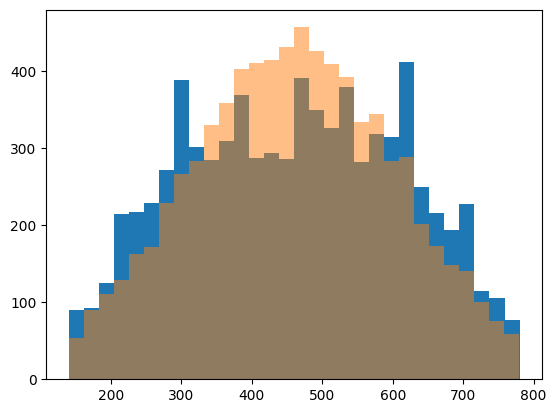

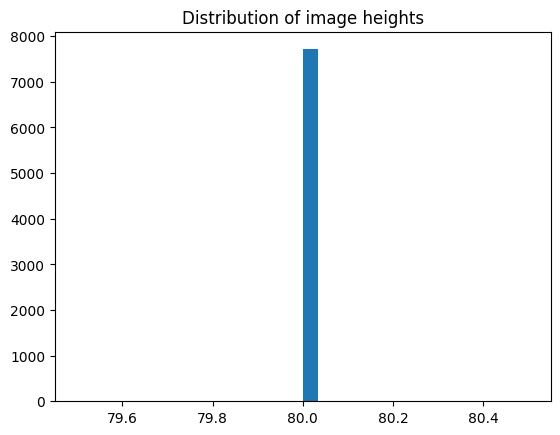

In [7]:
dataset_explore = CaptchaDataset(image_folder="../data/preprocessed_images", transform=None)
# plot image dimensions distribution in the dataset
widths = list(map(lambda image: image.size[0], dataset_explore))
plt.hist(widths, bins=30)

# fit a normal distribution to the data
min_width = min(widths)
max_width = max(widths)
mu, std = norm.fit(widths)

# sample and compare
sampled_widths = norm.rvs(mu, std, 8000)
sampled_widths = sampled_widths[(sampled_widths >= min_width) & (sampled_widths <= max_width)]
plt.hist(sampled_widths, bins=30, alpha=0.5)
plt.show()


heights = list(map(lambda image: image.size[1], dataset_explore))
plt.hist(heights, bins=30)
plt.title("Distribution of image heights")
plt.show()

### Captcha generation pipeline
Use PIL to generate a captcha image of size (w, 80)
where w is sampled using normal distribution params obtained above

For each image, randomly choose these params:
1. width: image width sampled from distribution above
1. font: text font in a captcha, random chosen in a pre-defined subset.
    - TODO: generate captcha that contains more than 1 font
1. font_size: font size of each letter
1. gap: (expected) spearation between each 2 letters
1. center_height: (expected) central height of letters

For each character in the image, randomly choose these params:
1. char: the character itself, in alphanumeric
1. x_displacement: small horizontal displacement
1. y_displacement: small vertical displacement
1. rotation: anticlockwise rotation in degrees

Use these params to draw letters in binary format until right margin

In [27]:
# Known values
MU = mu
STD = std
MIN_WIDTH = min_width
MAX_WIDTH = max_width
print(f"mu: {MU}, std: {STD}, min_width: {MIN_WIDTH}, max_width: {MAX_WIDTH}")

LEFT_MARGIN = 30 # if x position is below this value, regenerate

HEIGHT = 80
FONT_FILENAMES = [f for f in os.listdir("fonts") if f.endswith('.ttf')]
FONTSIZE_MIN = 24
FONTSIZE_MAX = 40
GAP_MIN = 5 # should not be too high, need some overlap
GAP_MAX = 30

X_DISPLACEMENT_MIN = -5
X_DISPLACEMENT_MAX = 5
Y_DISPLACEMENT_MIN = -5
Y_DISPLACEMENT_MAX = 5
ROTATION_MIN = -20
ROTATION_MAX = 20

ALPHANUMERIC = ascii_letters + digits

mu: 459.92156100090756, std: 154.64145619671635, min_width: 140, max_width: 780


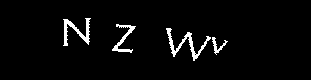

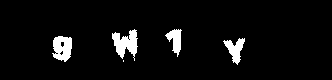

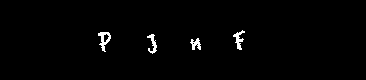

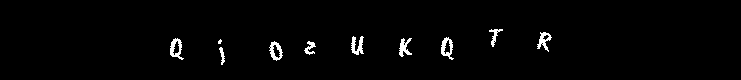

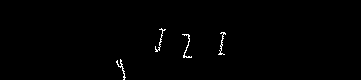

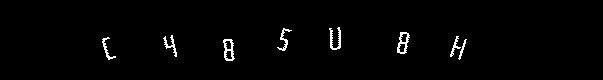

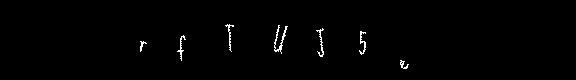

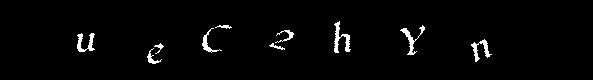

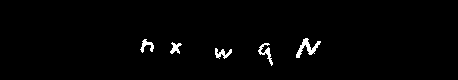

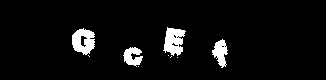

In [37]:
def get_random_width(mu, std, min_width, max_width):
    w = int(norm.rvs(mu, std))
    if w >= min_width and w <= max_width:
        return w
    return get_random_width(mu, std, min_width, max_width)


def generate_random_captcha():
    width = get_random_width(MU, STD, MIN_WIDTH, MAX_WIDTH)
    height = HEIGHT
    font_size = random.randint(FONTSIZE_MIN, FONTSIZE_MAX)
    font = ImageFont.truetype("./fonts/" + random.choice(FONT_FILENAMES), font_size)
    gap = random.randint(GAP_MIN, GAP_MAX)
    center_height = random.randint(HEIGHT // 20 * 9, HEIGHT // 20 * 11)

    # Approximation for the number of characters
    # TODO: check distribution of num characters generated and change this if needed
    num_chars = max(min((width - LEFT_MARGIN * 2) // 70, 9), 4)

    img = Image.new('1', (width, height))
    for i in range(num_chars):
        # Draw a character (pun intended)
        char = random.choice(ALPHANUMERIC)

        expected_x_disp_in_characters_from_center = i - num_chars / 2
        expected_x_start = width / 2 + (font_size + gap) * expected_x_disp_in_characters_from_center

        # TODO: check distribution, change random function if needed (e.g. with some probability it should not have any displ or rotation)
        x_displacement = random.randint(X_DISPLACEMENT_MIN, X_DISPLACEMENT_MAX)
        y_displacement = random.randint(Y_DISPLACEMENT_MIN, Y_DISPLACEMENT_MAX)
        rotation = random.randint(ROTATION_MIN, ROTATION_MAX)

        x_start = int(expected_x_start + x_displacement)
        char_height = font.getmetrics()[0] + font.getmetrics()[1] # ascent + descent
        y_start = int(center_height - char_height / 2 + y_displacement)

        # regenerate if out of bounds
        if x_start < LEFT_MARGIN:
            return generate_random_captcha()
        elif y_start + char_height > height or y_start < 0:
            return generate_random_captcha()

        text_img = Image.new('L', (char_height, char_height))
        text_draw = ImageDraw.Draw(text_img)
        text_draw.text((0, 0), char, font=font, fill=255, spacing=0)
        text_img = text_img.rotate(rotation, expand=True)
        img.paste(text_img, (x_start, y_start), text_img)

    return img

for i in range(10):
    img = generate_random_captcha()
    display(img)

In [38]:
def display_image(img_tensor):
    img_array = ((img_tensor.numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
    img_array[img_array < 128] = 0
    img_array[img_array >= 128] = 255
    display(Image.fromarray(img_array[0], 'L'))

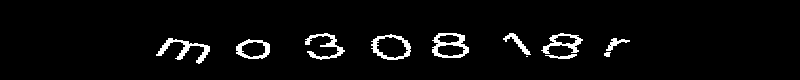

In [40]:
display_image(dataset[11])

In [ ]:
class Generator(nn.Module):
    def __init__(self, img_channels=1, feature_g=64, num_res_blocks = 4):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, feature_g, 3, 1, 1),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(feature_g, feature_g, 3, 1, 1),
                # nn.BatchNorm2d(feature_g),
                nn.ReLU(inplace=True),
                nn.Conv2d(feature_g, feature_g, 3, 1, 1),
                # nn.BatchNorm2d(feature_g)
            )
         for _ in range(num_res_blocks)])

        self.final = nn.Sequential(
            nn.Conv2d(feature_g, img_channels, 1, 1, 0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        for b in self.residual_blocks:
            x = x + b(x)
        x = self.final(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_d=128):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 80 * 800
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(feature_d),
            # 40 * 400
            nn.ReLU(),


            nn.Conv2d(feature_d, feature_d // 2, 4, 2, 1, bias=False),
            # 20 * 200
            # nn.BatchNorm2d(feature_d * 2),
            nn.MaxPool2d((2, 2), (2, 2)),
            # 10 * 80
            nn.ReLU(),

            nn.Conv2d(feature_d // 2, feature_d // 4, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(feature_d * 4),
            # 5 * 40
            nn.ReLU(),

            nn.Conv2d(feature_d // 4, 1, 5, 1, 0),
            # 1 * 36

            nn.AdaptiveAvgPool2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
def self_regularisation_loss(fake, real, delta=1e-5):
    return delta * torch.sum(torch.abs(fake - real))

optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rate_D, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rate_G, betas=(0.5, 0.999))

clip_grad_norm_(netG.parameters(), 1)

tensor(0.)

In [48]:
import gc

gc.collect()

torch.cuda.empty_cache()

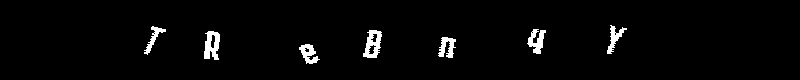

Epoch [0/10] Batch 0/483 Loss D: 1.3854, Loss G: 10.2265
Epoch [0/10] Batch 1/483 Loss D: 1.3873, Loss G: 1.2370
Epoch [0/10] Batch 2/483 Loss D: 1.3858, Loss G: 0.9447
Epoch [0/10] Batch 3/483 Loss D: 1.3834, Loss G: 0.7645
Epoch [0/10] Batch 4/483 Loss D: 1.3794, Loss G: 0.8315


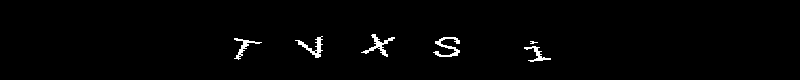

Epoch [0/10] Batch 5/483 Loss D: 1.3825, Loss G: 0.7636
Epoch [0/10] Batch 6/483 Loss D: 1.3783, Loss G: 0.7571
Epoch [0/10] Batch 7/483 Loss D: 1.3777, Loss G: 0.7716
Epoch [0/10] Batch 8/483 Loss D: 1.3687, Loss G: 0.7634
Epoch [0/10] Batch 9/483 Loss D: 1.3664, Loss G: 0.7428


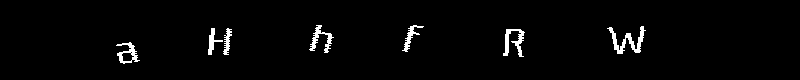

Epoch [0/10] Batch 10/483 Loss D: 1.3709, Loss G: 0.7316
Epoch [0/10] Batch 11/483 Loss D: 1.3447, Loss G: 0.7194
Epoch [0/10] Batch 12/483 Loss D: 1.3549, Loss G: 0.7136
Epoch [0/10] Batch 13/483 Loss D: 1.3435, Loss G: 0.7190
Epoch [0/10] Batch 14/483 Loss D: 1.3504, Loss G: 0.7072


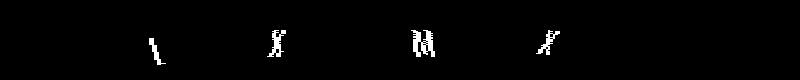

Epoch [0/10] Batch 15/483 Loss D: 1.3243, Loss G: 0.7118
Epoch [0/10] Batch 16/483 Loss D: 1.3438, Loss G: 0.6921
Epoch [0/10] Batch 17/483 Loss D: 1.3096, Loss G: 0.7092
Epoch [0/10] Batch 18/483 Loss D: 1.2893, Loss G: 0.7184


KeyboardInterrupt: 

In [49]:
for epoch in range(num_epochs):
    for i, images in enumerate(dataloader):
        real_imgs = images.to(device)
        b_size = real_imgs.size(0)

        # Labels
        y_true_real = torch.full((b_size, 1), 0.9, device=device)
        y_true_fake = torch.full((b_size, 1), 0.1, device=device)

        # Fake images
        fake_imgs = [transform(generate_random_captcha()) for _ in range(b_size)]
        fake_imgs = torch.stack(fake_imgs).reshape(b_size, 1, 80, 800).to(device)
        fake_imgs_refined = netG(fake_imgs) # go through generator to apply pixel-level adjustments

        if not i % 5:
            display_image(fake_imgs[0].cpu().detach())

        # ---- Train Discriminator ----

        # Real images
        y_pred_real = netD(real_imgs).view(-1, 1)
        lossD_real = criterion(y_pred_real, y_true_real)
        y_pred_fake = netD(fake_imgs_refined.detach()).view(-1, 1)
        lossD_fake = criterion(y_pred_fake, y_true_fake)

        lossD = lossD_real + lossD_fake

        netD.zero_grad()
        optimizerD.zero_grad()
        lossD.backward()
        optimizerD.step()

        # ---- Train Generator ----
        netG.zero_grad()
        netD.zero_grad()
        optimizerG.zero_grad()

        # Try to fool the discriminator
        y_pred_fake_for_G = netD(fake_imgs_refined).view(-1, 1)
        lossG_bce = criterion(y_pred_fake_for_G, y_true_real)
        lossG_self_reg = self_regularisation_loss(fake_imgs_refined, fake_imgs)
        lossG = lossG_bce + lossG_self_reg
        lossG.backward()
        optimizerG.step()

        if i % 1 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} "
                  f"Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

tensor([[[[0.4494]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3555]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2693]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3677]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5358]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3344]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3048]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2994]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1743]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.0929]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2214]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3316]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3312]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5734]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1626]]]], device='cuda:0', grad_fn=

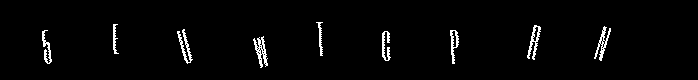

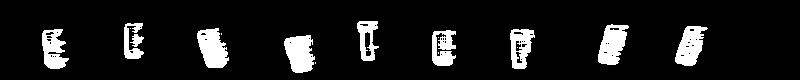

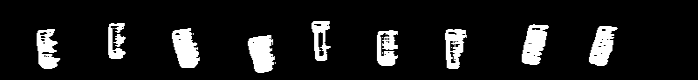

tensor([[[[0.1158]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3808]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4546]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6046]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4613]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5453]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1707]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7116]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


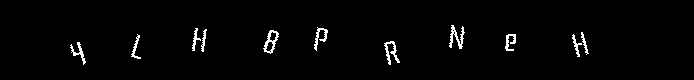

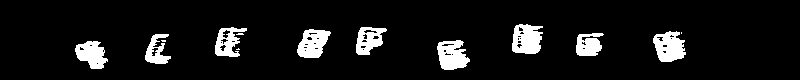

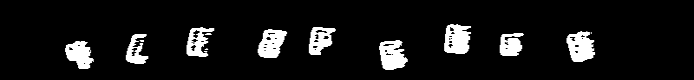

tensor([[[[0.5458]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4368]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2241]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3817]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4512]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5369]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2200]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3069]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4723]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6191]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5543]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2030]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3592]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4213]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3350]]]], device='cuda:0', grad_fn=

In [ ]:
def display_image_ori_width(img_tensor, ori_width):
    img_array = ((img_tensor.numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
    img_array[img_array < 128] = 0
    img_array[img_array >= 128] = 255
    display(Image.fromarray(img_array[0], 'L').resize((ori_width, 80), resample=3))

for _ in range(100):
  random_captcha = generate_random_captcha()
  width = random_captcha.size[0]
  generator_output = netG(torch.stack([transform(random_captcha)]).to(device))
  verdict = netD(generator_output)
  print(verdict)
  if verdict > 0.7:
    generator_output = generator_output[0].cpu().detach()
    display(random_captcha)
    display_image(generator_output)
    display_image_ori_width(generator_output, width)


## Previous training

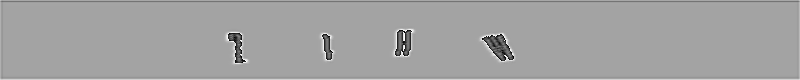

Epoch [0/10] Batch 0/121 Loss D: 1.3776, Loss G: 0.9836
Epoch [0/10] Batch 1/121 Loss D: 1.3537, Loss G: 0.9516
Epoch [0/10] Batch 2/121 Loss D: 1.4137, Loss G: 0.8157
Epoch [0/10] Batch 3/121 Loss D: 1.3620, Loss G: 0.8385
Epoch [0/10] Batch 4/121 Loss D: 1.3962, Loss G: 0.7564


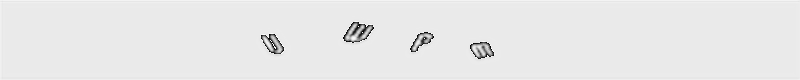

Epoch [0/10] Batch 5/121 Loss D: 1.3642, Loss G: 0.7728
Epoch [0/10] Batch 6/121 Loss D: 1.3967, Loss G: 0.7158
Epoch [0/10] Batch 7/121 Loss D: 1.3734, Loss G: 0.7256
Epoch [0/10] Batch 8/121 Loss D: 1.3935, Loss G: 0.6939
Epoch [0/10] Batch 9/121 Loss D: 1.3814, Loss G: 0.7004


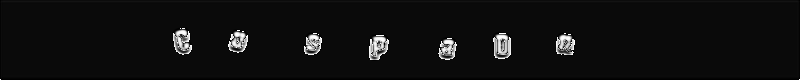

Epoch [0/10] Batch 10/121 Loss D: 1.3772, Loss G: 0.6882
Epoch [0/10] Batch 11/121 Loss D: 1.3771, Loss G: 0.6745
Epoch [0/10] Batch 12/121 Loss D: 1.3662, Loss G: 0.6804
Epoch [0/10] Batch 13/121 Loss D: 1.3681, Loss G: 0.6826
Epoch [0/10] Batch 14/121 Loss D: 1.3799, Loss G: 0.6761


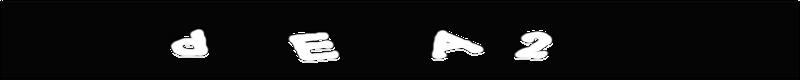

Epoch [0/10] Batch 15/121 Loss D: 1.3723, Loss G: 0.6832
Epoch [0/10] Batch 16/121 Loss D: 1.3728, Loss G: 0.6875
Epoch [0/10] Batch 17/121 Loss D: 1.3727, Loss G: 0.6960
Epoch [0/10] Batch 18/121 Loss D: 1.3809, Loss G: 0.6920
Epoch [0/10] Batch 19/121 Loss D: 1.3781, Loss G: 0.6914


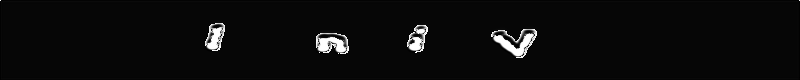

Epoch [0/10] Batch 20/121 Loss D: 1.3827, Loss G: 0.6856
Epoch [0/10] Batch 21/121 Loss D: 1.3882, Loss G: 0.6787
Epoch [0/10] Batch 22/121 Loss D: 1.3783, Loss G: 0.6827
Epoch [0/10] Batch 23/121 Loss D: 1.3738, Loss G: 0.6841
Epoch [0/10] Batch 24/121 Loss D: 1.3672, Loss G: 0.6950


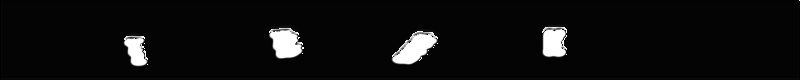

Epoch [0/10] Batch 25/121 Loss D: 1.3646, Loss G: 0.6930
Epoch [0/10] Batch 26/121 Loss D: 1.3647, Loss G: 0.6950
Epoch [0/10] Batch 27/121 Loss D: 1.3665, Loss G: 0.6961
Epoch [0/10] Batch 28/121 Loss D: 1.3734, Loss G: 0.6893
Epoch [0/10] Batch 29/121 Loss D: 1.3599, Loss G: 0.6915


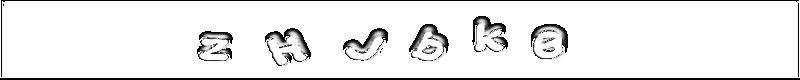

Epoch [0/10] Batch 30/121 Loss D: 1.3675, Loss G: 0.6792
Epoch [0/10] Batch 31/121 Loss D: 1.3420, Loss G: 0.7136
Epoch [0/10] Batch 32/121 Loss D: 1.3560, Loss G: 0.6848
Epoch [0/10] Batch 33/121 Loss D: 1.3526, Loss G: 0.6807
Epoch [0/10] Batch 34/121 Loss D: 1.3603, Loss G: 0.6702


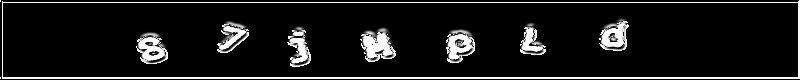

Epoch [0/10] Batch 35/121 Loss D: 1.3765, Loss G: 0.6569
Epoch [0/10] Batch 36/121 Loss D: 1.3636, Loss G: 0.6596
Epoch [0/10] Batch 37/121 Loss D: 1.3690, Loss G: 0.6604
Epoch [0/10] Batch 38/121 Loss D: 1.3629, Loss G: 0.6715
Epoch [0/10] Batch 39/121 Loss D: 1.3638, Loss G: 0.6710


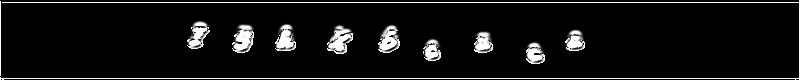

Epoch [0/10] Batch 40/121 Loss D: 1.3623, Loss G: 0.6699
Epoch [0/10] Batch 41/121 Loss D: 1.3557, Loss G: 0.6736
Epoch [0/10] Batch 42/121 Loss D: 1.3665, Loss G: 0.6633
Epoch [0/10] Batch 43/121 Loss D: 1.3577, Loss G: 0.6788
Epoch [0/10] Batch 44/121 Loss D: 1.3525, Loss G: 0.6793


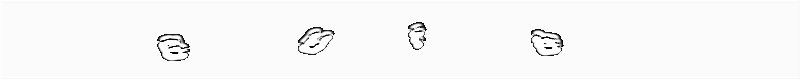

Epoch [0/10] Batch 45/121 Loss D: 1.3630, Loss G: 0.6782
Epoch [0/10] Batch 46/121 Loss D: 1.3687, Loss G: 0.6809
Epoch [0/10] Batch 47/121 Loss D: 1.3399, Loss G: 0.6986
Epoch [0/10] Batch 48/121 Loss D: 1.3653, Loss G: 0.6867
Epoch [0/10] Batch 49/121 Loss D: 1.3610, Loss G: 0.6924


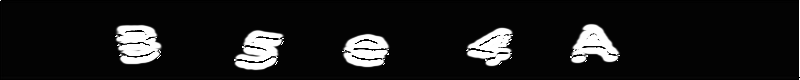

Epoch [0/10] Batch 50/121 Loss D: 1.3456, Loss G: 0.6871
Epoch [0/10] Batch 51/121 Loss D: 1.3621, Loss G: 0.6877
Epoch [0/10] Batch 52/121 Loss D: 1.3605, Loss G: 0.6869
Epoch [0/10] Batch 53/121 Loss D: 1.3480, Loss G: 0.6863
Epoch [0/10] Batch 54/121 Loss D: 1.3439, Loss G: 0.6792


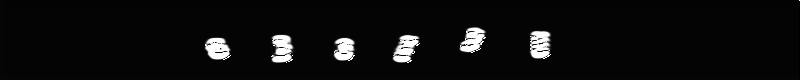

Epoch [0/10] Batch 55/121 Loss D: 1.3641, Loss G: 0.6775
Epoch [0/10] Batch 56/121 Loss D: 1.3703, Loss G: 0.6872
Epoch [0/10] Batch 57/121 Loss D: 1.3524, Loss G: 0.6989
Epoch [0/10] Batch 58/121 Loss D: 1.3590, Loss G: 0.6903
Epoch [0/10] Batch 59/121 Loss D: 1.3691, Loss G: 0.6890


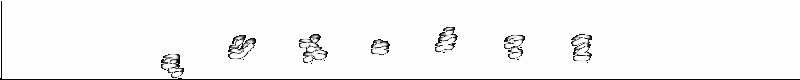

Epoch [0/10] Batch 60/121 Loss D: 1.3372, Loss G: 0.6878
Epoch [0/10] Batch 61/121 Loss D: 1.3625, Loss G: 0.6809
Epoch [0/10] Batch 62/121 Loss D: 1.3431, Loss G: 0.6826
Epoch [0/10] Batch 63/121 Loss D: 1.3641, Loss G: 0.6797
Epoch [0/10] Batch 64/121 Loss D: 1.3473, Loss G: 0.6774


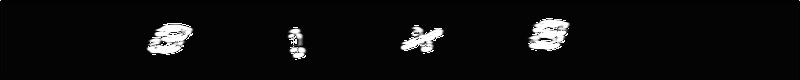

Epoch [0/10] Batch 65/121 Loss D: 1.3501, Loss G: 0.6700
Epoch [0/10] Batch 66/121 Loss D: 1.3528, Loss G: 0.6680
Epoch [0/10] Batch 67/121 Loss D: 1.3512, Loss G: 0.6673
Epoch [0/10] Batch 68/121 Loss D: 1.3598, Loss G: 0.6690
Epoch [0/10] Batch 69/121 Loss D: 1.3632, Loss G: 0.6826


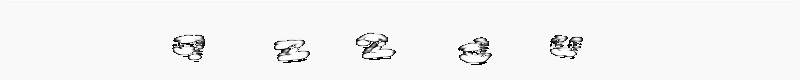

Epoch [0/10] Batch 70/121 Loss D: 1.3509, Loss G: 0.6836
Epoch [0/10] Batch 71/121 Loss D: 1.3339, Loss G: 0.6769
Epoch [0/10] Batch 72/121 Loss D: 1.3713, Loss G: 0.6587
Epoch [0/10] Batch 73/121 Loss D: 1.3435, Loss G: 0.6887
Epoch [0/10] Batch 74/121 Loss D: 1.3386, Loss G: 0.6729


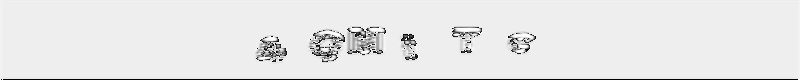

Epoch [0/10] Batch 75/121 Loss D: 1.3108, Loss G: 0.6935
Epoch [0/10] Batch 76/121 Loss D: 1.2617, Loss G: 0.7568
Epoch [0/10] Batch 77/121 Loss D: 1.2638, Loss G: 0.8013
Epoch [0/10] Batch 78/121 Loss D: 1.2168, Loss G: 0.8009
Epoch [0/10] Batch 79/121 Loss D: 1.2122, Loss G: 0.7841


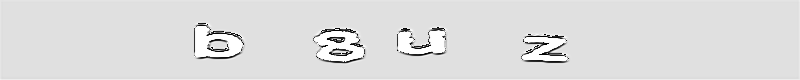

Epoch [0/10] Batch 80/121 Loss D: 1.2855, Loss G: 0.6731
Epoch [0/10] Batch 81/121 Loss D: 1.3241, Loss G: 0.6506
Epoch [0/10] Batch 82/121 Loss D: 0.8816, Loss G: 1.5411
Epoch [0/10] Batch 83/121 Loss D: 1.2642, Loss G: 0.6617
Epoch [0/10] Batch 84/121 Loss D: 1.2715, Loss G: 0.6644


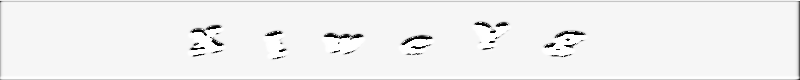

Epoch [0/10] Batch 85/121 Loss D: 0.9619, Loss G: 1.0963
Epoch [0/10] Batch 86/121 Loss D: 1.1961, Loss G: 0.6829
Epoch [0/10] Batch 87/121 Loss D: 1.2464, Loss G: 0.6755
Epoch [0/10] Batch 88/121 Loss D: 1.2914, Loss G: 0.6491
Epoch [0/10] Batch 89/121 Loss D: 1.2782, Loss G: 0.6386


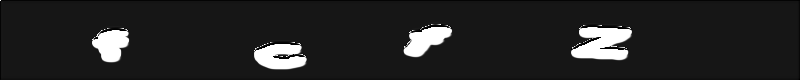

Epoch [0/10] Batch 90/121 Loss D: 1.2916, Loss G: 0.6913
Epoch [0/10] Batch 91/121 Loss D: 1.2855, Loss G: 0.6891
Epoch [0/10] Batch 92/121 Loss D: 1.3528, Loss G: 0.6957
Epoch [0/10] Batch 93/121 Loss D: 1.3242, Loss G: 0.7368
Epoch [0/10] Batch 94/121 Loss D: 1.3069, Loss G: 0.7700


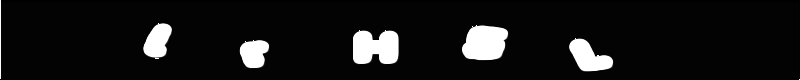

Epoch [0/10] Batch 95/121 Loss D: 1.3242, Loss G: 0.7918
Epoch [0/10] Batch 96/121 Loss D: 1.2855, Loss G: 0.7971
Epoch [0/10] Batch 97/121 Loss D: 1.2986, Loss G: 0.8079
Epoch [0/10] Batch 98/121 Loss D: 1.2681, Loss G: 0.8392
Epoch [0/10] Batch 99/121 Loss D: 1.3036, Loss G: 0.8018


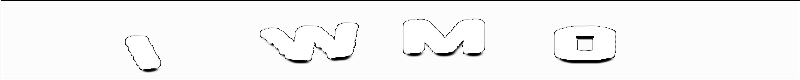

Epoch [0/10] Batch 100/121 Loss D: 1.3042, Loss G: 0.7729
Epoch [0/10] Batch 101/121 Loss D: 1.3014, Loss G: 0.7525
Epoch [0/10] Batch 102/121 Loss D: 1.3012, Loss G: 0.7369
Epoch [0/10] Batch 103/121 Loss D: 1.3238, Loss G: 0.7214
Epoch [0/10] Batch 104/121 Loss D: 1.3074, Loss G: 0.7167


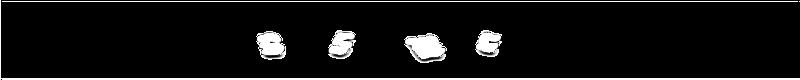

Epoch [0/10] Batch 105/121 Loss D: 1.2816, Loss G: 0.7114
Epoch [0/10] Batch 106/121 Loss D: 1.3233, Loss G: 0.7029
Epoch [0/10] Batch 107/121 Loss D: 1.3393, Loss G: 0.7069
Epoch [0/10] Batch 108/121 Loss D: 1.2771, Loss G: 0.7440
Epoch [0/10] Batch 109/121 Loss D: 1.3163, Loss G: 0.7067


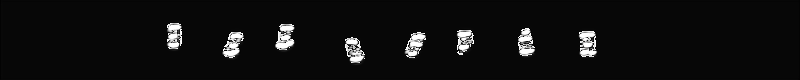

Epoch [0/10] Batch 110/121 Loss D: 1.3202, Loss G: 0.7024
Epoch [0/10] Batch 111/121 Loss D: 1.3385, Loss G: 0.6781
Epoch [0/10] Batch 112/121 Loss D: 1.3078, Loss G: 0.7045
Epoch [0/10] Batch 113/121 Loss D: 1.3229, Loss G: 0.6830
Epoch [0/10] Batch 114/121 Loss D: 1.3122, Loss G: 0.6827


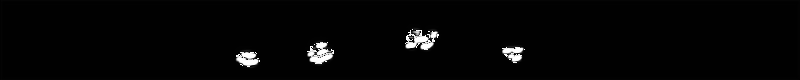

Epoch [0/10] Batch 115/121 Loss D: 1.3717, Loss G: 0.6539
Epoch [0/10] Batch 116/121 Loss D: 1.3177, Loss G: 0.6751
Epoch [0/10] Batch 117/121 Loss D: 1.2998, Loss G: 0.7045
Epoch [0/10] Batch 118/121 Loss D: 1.3361, Loss G: 0.6908
Epoch [0/10] Batch 119/121 Loss D: 1.3246, Loss G: 0.6899


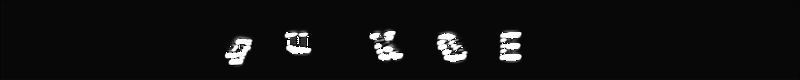

Epoch [0/10] Batch 120/121 Loss D: 1.3000, Loss G: 0.6960


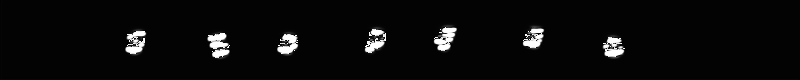

Epoch [1/10] Batch 0/121 Loss D: 1.3581, Loss G: 0.6703
Epoch [1/10] Batch 1/121 Loss D: 1.3460, Loss G: 0.6781
Epoch [1/10] Batch 2/121 Loss D: 1.3489, Loss G: 0.6856
Epoch [1/10] Batch 3/121 Loss D: 1.3050, Loss G: 0.6999
Epoch [1/10] Batch 4/121 Loss D: 1.3299, Loss G: 0.6876


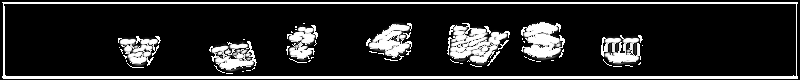

Epoch [1/10] Batch 5/121 Loss D: 1.3318, Loss G: 0.6824
Epoch [1/10] Batch 6/121 Loss D: 1.3411, Loss G: 0.7012
Epoch [1/10] Batch 7/121 Loss D: 1.3423, Loss G: 0.6914
Epoch [1/10] Batch 8/121 Loss D: 1.3176, Loss G: 0.6882
Epoch [1/10] Batch 9/121 Loss D: 1.3207, Loss G: 0.7003


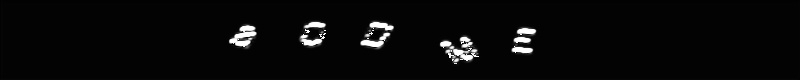

Epoch [1/10] Batch 10/121 Loss D: 1.3080, Loss G: 0.7350
Epoch [1/10] Batch 11/121 Loss D: 1.3378, Loss G: 0.7083
Epoch [1/10] Batch 12/121 Loss D: 1.3237, Loss G: 0.6944
Epoch [1/10] Batch 13/121 Loss D: 1.3270, Loss G: 0.7036
Epoch [1/10] Batch 14/121 Loss D: 1.3201, Loss G: 0.7102


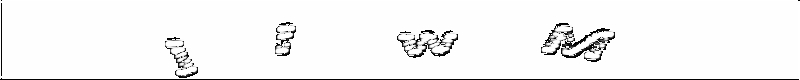

Epoch [1/10] Batch 15/121 Loss D: 1.3239, Loss G: 0.7125
Epoch [1/10] Batch 16/121 Loss D: 1.3291, Loss G: 0.7003
Epoch [1/10] Batch 17/121 Loss D: 1.2851, Loss G: 0.7201
Epoch [1/10] Batch 18/121 Loss D: 1.2685, Loss G: 0.7410
Epoch [1/10] Batch 19/121 Loss D: 1.2904, Loss G: 0.6932


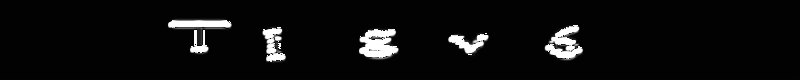

Epoch [1/10] Batch 20/121 Loss D: 1.3002, Loss G: 0.7183
Epoch [1/10] Batch 21/121 Loss D: 1.3039, Loss G: 0.7235
Epoch [1/10] Batch 22/121 Loss D: 1.3310, Loss G: 0.7261
Epoch [1/10] Batch 23/121 Loss D: 1.3138, Loss G: 0.7075
Epoch [1/10] Batch 24/121 Loss D: 1.2675, Loss G: 0.7390


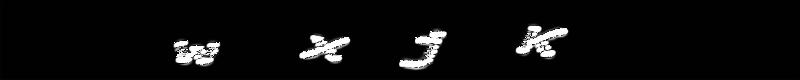

Epoch [1/10] Batch 25/121 Loss D: 1.3516, Loss G: 0.7073
Epoch [1/10] Batch 26/121 Loss D: 1.3388, Loss G: 0.7381
Epoch [1/10] Batch 27/121 Loss D: 1.3523, Loss G: 0.7045
Epoch [1/10] Batch 28/121 Loss D: 1.3445, Loss G: 0.7102
Epoch [1/10] Batch 29/121 Loss D: 1.3069, Loss G: 0.6979


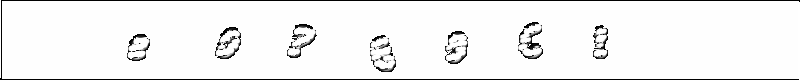

Epoch [1/10] Batch 30/121 Loss D: 1.2731, Loss G: 0.7424
Epoch [1/10] Batch 31/121 Loss D: 1.3333, Loss G: 0.7064
Epoch [1/10] Batch 32/121 Loss D: 1.2795, Loss G: 0.7330
Epoch [1/10] Batch 33/121 Loss D: 1.3283, Loss G: 0.7445
Epoch [1/10] Batch 34/121 Loss D: 1.3041, Loss G: 0.7352


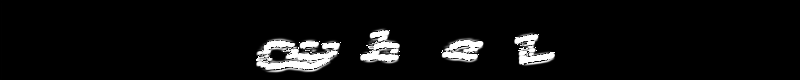

Epoch [1/10] Batch 35/121 Loss D: 1.2970, Loss G: 0.7274
Epoch [1/10] Batch 36/121 Loss D: 1.3167, Loss G: 0.7398
Epoch [1/10] Batch 37/121 Loss D: 1.3151, Loss G: 0.7210
Epoch [1/10] Batch 38/121 Loss D: 1.2987, Loss G: 0.7231
Epoch [1/10] Batch 39/121 Loss D: 1.3214, Loss G: 0.7216


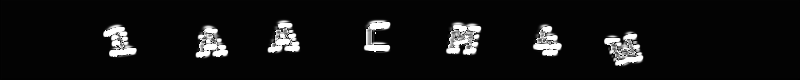

Epoch [1/10] Batch 40/121 Loss D: 1.3260, Loss G: 0.7121
Epoch [1/10] Batch 41/121 Loss D: 1.3001, Loss G: 0.7262
Epoch [1/10] Batch 42/121 Loss D: 1.2773, Loss G: 0.7576
Epoch [1/10] Batch 43/121 Loss D: 1.3267, Loss G: 0.7203
Epoch [1/10] Batch 44/121 Loss D: 1.3110, Loss G: 0.7137


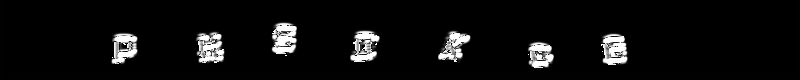

Epoch [1/10] Batch 45/121 Loss D: 1.3379, Loss G: 0.7205
Epoch [1/10] Batch 46/121 Loss D: 1.3104, Loss G: 0.7341
Epoch [1/10] Batch 47/121 Loss D: 1.2924, Loss G: 0.7747
Epoch [1/10] Batch 48/121 Loss D: 1.2715, Loss G: 0.7811
Epoch [1/10] Batch 49/121 Loss D: 1.3062, Loss G: 0.7580


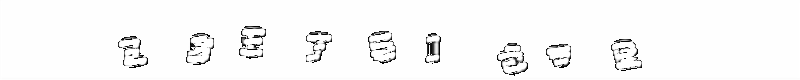

Epoch [1/10] Batch 50/121 Loss D: 1.3022, Loss G: 0.7607
Epoch [1/10] Batch 51/121 Loss D: 1.2930, Loss G: 0.7228
Epoch [1/10] Batch 52/121 Loss D: 1.3372, Loss G: 0.7320
Epoch [1/10] Batch 53/121 Loss D: 1.3125, Loss G: 0.7326
Epoch [1/10] Batch 54/121 Loss D: 1.2998, Loss G: 0.7387


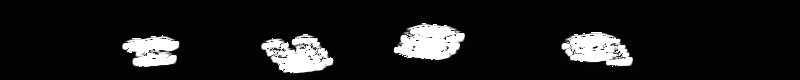

Epoch [1/10] Batch 55/121 Loss D: 1.3171, Loss G: 0.7216
Epoch [1/10] Batch 56/121 Loss D: 1.2888, Loss G: 0.7507
Epoch [1/10] Batch 57/121 Loss D: 1.2647, Loss G: 0.7718
Epoch [1/10] Batch 58/121 Loss D: 1.3299, Loss G: 0.7190
Epoch [1/10] Batch 59/121 Loss D: 1.3163, Loss G: 0.7227


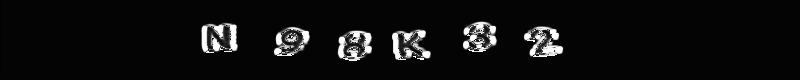

Epoch [1/10] Batch 60/121 Loss D: 1.2507, Loss G: 0.7997
Epoch [1/10] Batch 61/121 Loss D: 1.3173, Loss G: 0.7190
Epoch [1/10] Batch 62/121 Loss D: 1.3394, Loss G: 0.7377
Epoch [1/10] Batch 63/121 Loss D: 1.3086, Loss G: 0.7561
Epoch [1/10] Batch 64/121 Loss D: 1.3713, Loss G: 0.7087


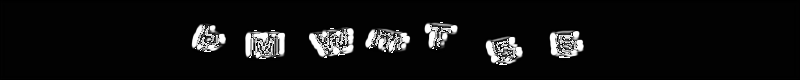

Epoch [1/10] Batch 65/121 Loss D: 1.3220, Loss G: 0.7226
Epoch [1/10] Batch 66/121 Loss D: 1.2894, Loss G: 0.7512
Epoch [1/10] Batch 67/121 Loss D: 1.3066, Loss G: 0.7642
Epoch [1/10] Batch 68/121 Loss D: 1.3106, Loss G: 0.7510
Epoch [1/10] Batch 69/121 Loss D: 1.3241, Loss G: 0.7776


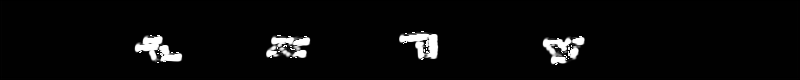

Epoch [1/10] Batch 70/121 Loss D: 1.2709, Loss G: 0.7771
Epoch [1/10] Batch 71/121 Loss D: 1.2886, Loss G: 0.7500
Epoch [1/10] Batch 72/121 Loss D: 1.3161, Loss G: 0.7397
Epoch [1/10] Batch 73/121 Loss D: 1.3027, Loss G: 0.7232
Epoch [1/10] Batch 74/121 Loss D: 1.3228, Loss G: 0.7247


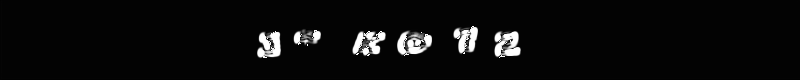

Epoch [1/10] Batch 75/121 Loss D: 1.2923, Loss G: 0.7755
Epoch [1/10] Batch 76/121 Loss D: 1.3004, Loss G: 0.7538
Epoch [1/10] Batch 77/121 Loss D: 1.2943, Loss G: 0.7881
Epoch [1/10] Batch 78/121 Loss D: 1.3145, Loss G: 0.7846
Epoch [1/10] Batch 79/121 Loss D: 1.3123, Loss G: 0.7627


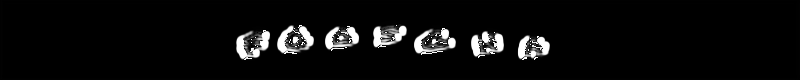

Epoch [1/10] Batch 80/121 Loss D: 1.3085, Loss G: 0.7876
Epoch [1/10] Batch 81/121 Loss D: 1.3647, Loss G: 0.7738
Epoch [1/10] Batch 82/121 Loss D: 1.3414, Loss G: 0.7406
Epoch [1/10] Batch 83/121 Loss D: 1.3402, Loss G: 0.7431
Epoch [1/10] Batch 84/121 Loss D: 1.2867, Loss G: 0.7857


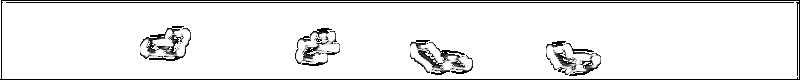

Epoch [1/10] Batch 85/121 Loss D: 1.2863, Loss G: 0.7494
Epoch [1/10] Batch 86/121 Loss D: 1.2516, Loss G: 0.7899
Epoch [1/10] Batch 87/121 Loss D: 1.3491, Loss G: 0.7557
Epoch [1/10] Batch 88/121 Loss D: 1.3521, Loss G: 0.7499
Epoch [1/10] Batch 89/121 Loss D: 1.2993, Loss G: 0.7461


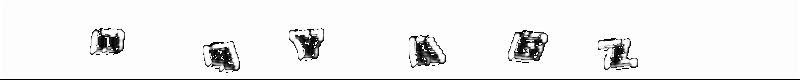

Epoch [1/10] Batch 90/121 Loss D: 1.2713, Loss G: 0.7650
Epoch [1/10] Batch 91/121 Loss D: 1.2975, Loss G: 0.7394
Epoch [1/10] Batch 92/121 Loss D: 1.2817, Loss G: 0.7446
Epoch [1/10] Batch 93/121 Loss D: 1.2577, Loss G: 0.7639
Epoch [1/10] Batch 94/121 Loss D: 1.3313, Loss G: 0.7702


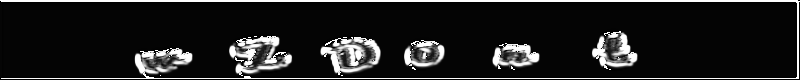

Epoch [1/10] Batch 95/121 Loss D: 1.2428, Loss G: 0.8075
Epoch [1/10] Batch 96/121 Loss D: 1.3166, Loss G: 0.7703
Epoch [1/10] Batch 97/121 Loss D: 1.2154, Loss G: 0.8204
Epoch [1/10] Batch 98/121 Loss D: 1.2448, Loss G: 0.8025
Epoch [1/10] Batch 99/121 Loss D: 1.3051, Loss G: 0.7165


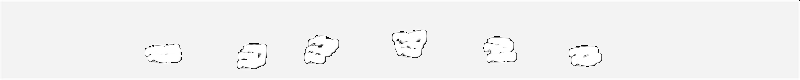

Epoch [1/10] Batch 100/121 Loss D: 1.2198, Loss G: 0.8126
Epoch [1/10] Batch 101/121 Loss D: 1.2559, Loss G: 0.7754
Epoch [1/10] Batch 102/121 Loss D: 1.2419, Loss G: 0.8682
Epoch [1/10] Batch 103/121 Loss D: 1.2802, Loss G: 0.7855
Epoch [1/10] Batch 104/121 Loss D: 1.1471, Loss G: 0.9599


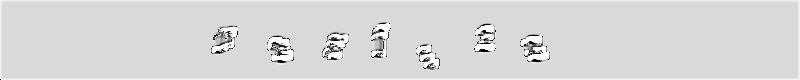

Epoch [1/10] Batch 105/121 Loss D: 1.1186, Loss G: 0.8707
Epoch [1/10] Batch 106/121 Loss D: 1.2634, Loss G: 0.7101
Epoch [1/10] Batch 107/121 Loss D: 1.2580, Loss G: 0.7165
Epoch [1/10] Batch 108/121 Loss D: 1.3120, Loss G: 0.7052
Epoch [1/10] Batch 109/121 Loss D: 1.2483, Loss G: 0.7863


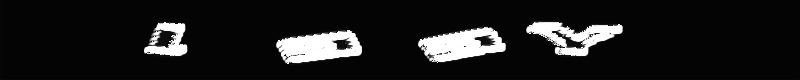

Epoch [1/10] Batch 110/121 Loss D: 1.2545, Loss G: 0.8067
Epoch [1/10] Batch 111/121 Loss D: 1.2272, Loss G: 0.8220
Epoch [1/10] Batch 112/121 Loss D: 1.2523, Loss G: 0.7989
Epoch [1/10] Batch 113/121 Loss D: 1.2976, Loss G: 0.7823
Epoch [1/10] Batch 114/121 Loss D: 1.3028, Loss G: 0.7209


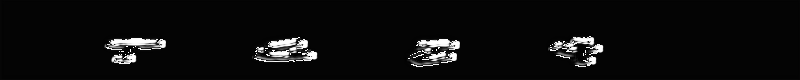

Epoch [1/10] Batch 115/121 Loss D: 1.2655, Loss G: 0.7073
Epoch [1/10] Batch 116/121 Loss D: 1.3225, Loss G: 0.6570
Epoch [1/10] Batch 117/121 Loss D: 1.2776, Loss G: 0.6918
Epoch [1/10] Batch 118/121 Loss D: 1.3036, Loss G: 0.6803
Epoch [1/10] Batch 119/121 Loss D: 1.2718, Loss G: 0.7641


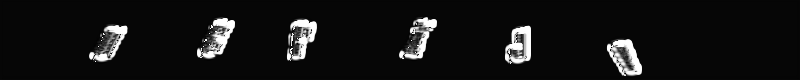

Epoch [1/10] Batch 120/121 Loss D: 1.1757, Loss G: 0.8388


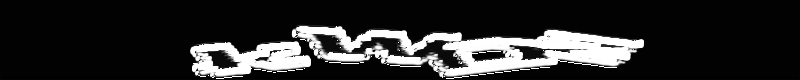

Epoch [2/10] Batch 0/121 Loss D: 1.2788, Loss G: 0.8195
Epoch [2/10] Batch 1/121 Loss D: 1.2879, Loss G: 0.8331
Epoch [2/10] Batch 2/121 Loss D: 1.2444, Loss G: 0.8204
Epoch [2/10] Batch 3/121 Loss D: 1.2983, Loss G: 0.7624
Epoch [2/10] Batch 4/121 Loss D: 1.2693, Loss G: 0.7514


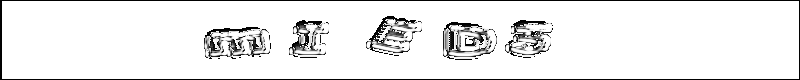

Epoch [2/10] Batch 5/121 Loss D: 1.2626, Loss G: 0.7677
Epoch [2/10] Batch 6/121 Loss D: 1.3440, Loss G: 0.7360
Epoch [2/10] Batch 7/121 Loss D: 1.2497, Loss G: 0.7918
Epoch [2/10] Batch 8/121 Loss D: 1.2411, Loss G: 0.7396
Epoch [2/10] Batch 9/121 Loss D: 1.2011, Loss G: 0.7833


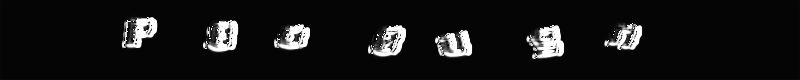

Epoch [2/10] Batch 10/121 Loss D: 1.2017, Loss G: 0.7858
Epoch [2/10] Batch 11/121 Loss D: 1.2255, Loss G: 0.7861
Epoch [2/10] Batch 12/121 Loss D: 1.2815, Loss G: 0.7495
Epoch [2/10] Batch 13/121 Loss D: 1.3484, Loss G: 0.7460
Epoch [2/10] Batch 14/121 Loss D: 1.2438, Loss G: 0.8002


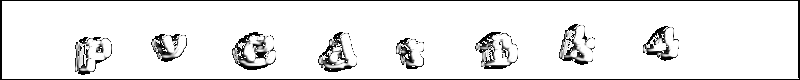

Epoch [2/10] Batch 15/121 Loss D: 1.2423, Loss G: 0.8083
Epoch [2/10] Batch 16/121 Loss D: 1.3316, Loss G: 0.7704
Epoch [2/10] Batch 17/121 Loss D: 1.2710, Loss G: 0.7733
Epoch [2/10] Batch 18/121 Loss D: 1.3260, Loss G: 0.7269
Epoch [2/10] Batch 19/121 Loss D: 1.2718, Loss G: 0.7504


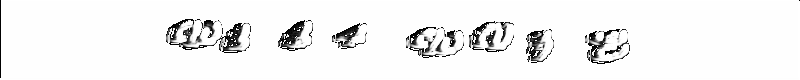

Epoch [2/10] Batch 20/121 Loss D: 1.2936, Loss G: 0.7483
Epoch [2/10] Batch 21/121 Loss D: 1.2190, Loss G: 0.7811
Epoch [2/10] Batch 22/121 Loss D: 1.3378, Loss G: 0.7499
Epoch [2/10] Batch 23/121 Loss D: 1.3135, Loss G: 0.7819
Epoch [2/10] Batch 24/121 Loss D: 1.2781, Loss G: 0.8087


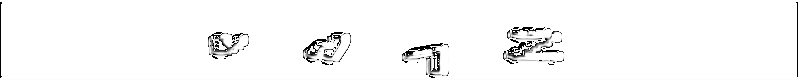

Epoch [2/10] Batch 25/121 Loss D: 1.2645, Loss G: 0.7706
Epoch [2/10] Batch 26/121 Loss D: 1.2938, Loss G: 0.7464
Epoch [2/10] Batch 27/121 Loss D: 1.2943, Loss G: 0.7348
Epoch [2/10] Batch 28/121 Loss D: 1.2383, Loss G: 0.7851
Epoch [2/10] Batch 29/121 Loss D: 1.2252, Loss G: 0.7459


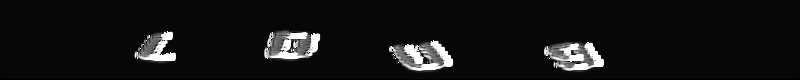

Epoch [2/10] Batch 30/121 Loss D: 1.2095, Loss G: 0.8412
Epoch [2/10] Batch 31/121 Loss D: 1.2754, Loss G: 0.7852
Epoch [2/10] Batch 32/121 Loss D: 1.2436, Loss G: 0.7933
Epoch [2/10] Batch 33/121 Loss D: 1.2264, Loss G: 0.7846
Epoch [2/10] Batch 34/121 Loss D: 1.2166, Loss G: 0.8150


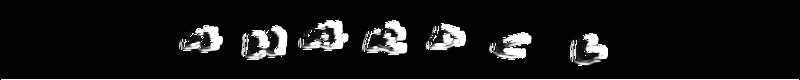

Epoch [2/10] Batch 35/121 Loss D: 1.2578, Loss G: 0.8059
Epoch [2/10] Batch 36/121 Loss D: 1.3084, Loss G: 0.7724
Epoch [2/10] Batch 37/121 Loss D: 1.3008, Loss G: 0.7637
Epoch [2/10] Batch 38/121 Loss D: 1.2453, Loss G: 0.7457
Epoch [2/10] Batch 39/121 Loss D: 1.2748, Loss G: 0.7464


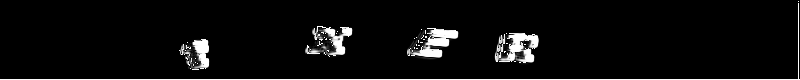

Epoch [2/10] Batch 40/121 Loss D: 1.2781, Loss G: 0.7317
Epoch [2/10] Batch 41/121 Loss D: 1.2375, Loss G: 0.7625
Epoch [2/10] Batch 42/121 Loss D: 1.2780, Loss G: 0.7625
Epoch [2/10] Batch 43/121 Loss D: 1.2817, Loss G: 0.7790
Epoch [2/10] Batch 44/121 Loss D: 1.1779, Loss G: 0.8282


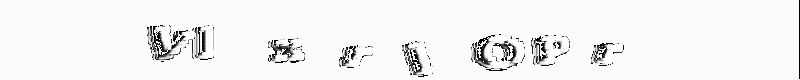

Epoch [2/10] Batch 45/121 Loss D: 1.2635, Loss G: 0.8064
Epoch [2/10] Batch 46/121 Loss D: 1.2481, Loss G: 0.7678
Epoch [2/10] Batch 47/121 Loss D: 1.1878, Loss G: 0.8075
Epoch [2/10] Batch 48/121 Loss D: 1.2216, Loss G: 0.8160
Epoch [2/10] Batch 49/121 Loss D: 1.2077, Loss G: 0.8259


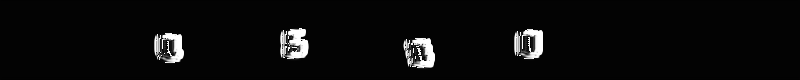

Epoch [2/10] Batch 50/121 Loss D: 1.2207, Loss G: 0.7906
Epoch [2/10] Batch 51/121 Loss D: 1.2297, Loss G: 0.7958
Epoch [2/10] Batch 52/121 Loss D: 1.2442, Loss G: 0.7746
Epoch [2/10] Batch 53/121 Loss D: 1.2571, Loss G: 0.7352
Epoch [2/10] Batch 54/121 Loss D: 1.2809, Loss G: 0.7698


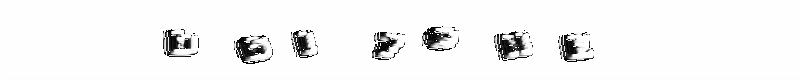

Epoch [2/10] Batch 55/121 Loss D: 1.1975, Loss G: 0.7948
Epoch [2/10] Batch 56/121 Loss D: 1.2077, Loss G: 0.7761
Epoch [2/10] Batch 57/121 Loss D: 1.2525, Loss G: 0.8175
Epoch [2/10] Batch 58/121 Loss D: 1.2955, Loss G: 0.8233
Epoch [2/10] Batch 59/121 Loss D: 1.1916, Loss G: 0.7736


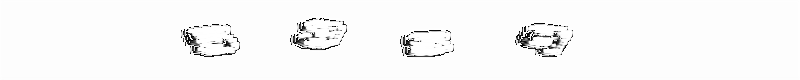

Epoch [2/10] Batch 60/121 Loss D: 1.1950, Loss G: 0.7949
Epoch [2/10] Batch 61/121 Loss D: 1.2578, Loss G: 0.7868
Epoch [2/10] Batch 62/121 Loss D: 1.2430, Loss G: 0.8070
Epoch [2/10] Batch 63/121 Loss D: 1.2852, Loss G: 0.7811
Epoch [2/10] Batch 64/121 Loss D: 1.2700, Loss G: 0.7708


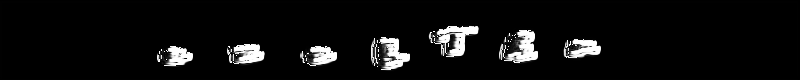

Epoch [2/10] Batch 65/121 Loss D: 1.2125, Loss G: 0.7941
Epoch [2/10] Batch 66/121 Loss D: 1.2531, Loss G: 0.8362
Epoch [2/10] Batch 67/121 Loss D: 1.2140, Loss G: 0.8123
Epoch [2/10] Batch 68/121 Loss D: 1.2496, Loss G: 0.8230
Epoch [2/10] Batch 69/121 Loss D: 1.2727, Loss G: 0.7668


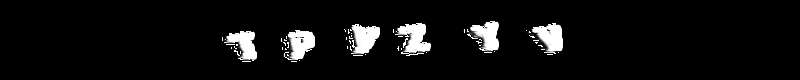

Epoch [2/10] Batch 70/121 Loss D: 1.2675, Loss G: 0.8195
Epoch [2/10] Batch 71/121 Loss D: 1.2400, Loss G: 0.7963
Epoch [2/10] Batch 72/121 Loss D: 1.2684, Loss G: 0.7675
Epoch [2/10] Batch 73/121 Loss D: 1.2993, Loss G: 0.7414
Epoch [2/10] Batch 74/121 Loss D: 1.2810, Loss G: 0.7308


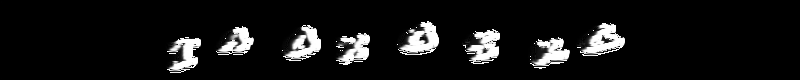

Epoch [2/10] Batch 75/121 Loss D: 1.2213, Loss G: 0.7901
Epoch [2/10] Batch 76/121 Loss D: 1.2397, Loss G: 0.7460
Epoch [2/10] Batch 77/121 Loss D: 1.2371, Loss G: 0.8364
Epoch [2/10] Batch 78/121 Loss D: 1.2055, Loss G: 0.7851
Epoch [2/10] Batch 79/121 Loss D: 1.2482, Loss G: 0.7605


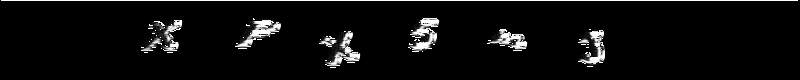

Epoch [2/10] Batch 80/121 Loss D: 1.2062, Loss G: 0.7362
Epoch [2/10] Batch 81/121 Loss D: 1.1645, Loss G: 0.7983
Epoch [2/10] Batch 82/121 Loss D: 1.2562, Loss G: 0.7163
Epoch [2/10] Batch 83/121 Loss D: 1.2963, Loss G: 0.7004
Epoch [2/10] Batch 84/121 Loss D: 1.2765, Loss G: 0.6892


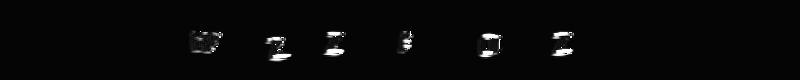

Epoch [2/10] Batch 85/121 Loss D: 1.2339, Loss G: 0.7117
Epoch [2/10] Batch 86/121 Loss D: 1.1965, Loss G: 0.7692
Epoch [2/10] Batch 87/121 Loss D: 1.2006, Loss G: 0.7205
Epoch [2/10] Batch 88/121 Loss D: 1.1913, Loss G: 0.8053
Epoch [2/10] Batch 89/121 Loss D: 1.1986, Loss G: 0.7928


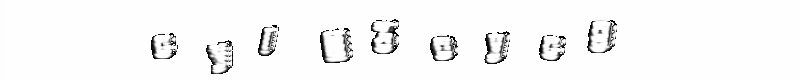

Epoch [2/10] Batch 90/121 Loss D: 1.1637, Loss G: 0.9123
Epoch [2/10] Batch 91/121 Loss D: 1.2238, Loss G: 0.9587
Epoch [2/10] Batch 92/121 Loss D: 1.2937, Loss G: 0.7682
Epoch [2/10] Batch 93/121 Loss D: 1.2123, Loss G: 0.8324
Epoch [2/10] Batch 94/121 Loss D: 1.3003, Loss G: 0.7280


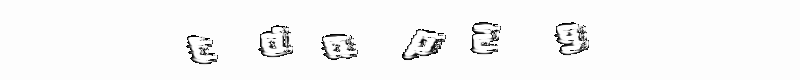

Epoch [2/10] Batch 95/121 Loss D: 1.1505, Loss G: 0.8030
Epoch [2/10] Batch 96/121 Loss D: 1.2912, Loss G: 0.7548
Epoch [2/10] Batch 97/121 Loss D: 1.2497, Loss G: 0.8277
Epoch [2/10] Batch 98/121 Loss D: 1.1646, Loss G: 0.8638
Epoch [2/10] Batch 99/121 Loss D: 1.2949, Loss G: 0.7796


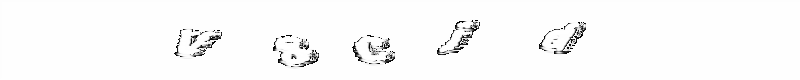

Epoch [2/10] Batch 100/121 Loss D: 1.2127, Loss G: 0.8556
Epoch [2/10] Batch 101/121 Loss D: 1.1820, Loss G: 0.7749
Epoch [2/10] Batch 102/121 Loss D: 1.2539, Loss G: 0.7449
Epoch [2/10] Batch 103/121 Loss D: 1.3245, Loss G: 0.7333
Epoch [2/10] Batch 104/121 Loss D: 1.1417, Loss G: 0.8695


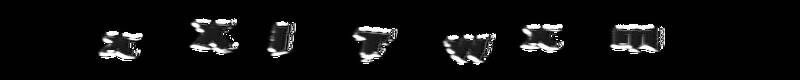

Epoch [2/10] Batch 105/121 Loss D: 1.1943, Loss G: 0.7954
Epoch [2/10] Batch 106/121 Loss D: 1.3040, Loss G: 0.7270
Epoch [2/10] Batch 107/121 Loss D: 1.2918, Loss G: 0.7103
Epoch [2/10] Batch 108/121 Loss D: 1.2238, Loss G: 0.7701
Epoch [2/10] Batch 109/121 Loss D: 1.1400, Loss G: 0.8012


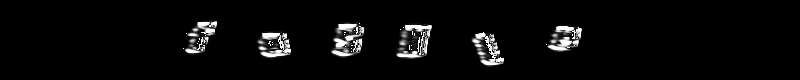

Epoch [2/10] Batch 110/121 Loss D: 1.2439, Loss G: 0.7691
Epoch [2/10] Batch 111/121 Loss D: 1.2273, Loss G: 0.7823
Epoch [2/10] Batch 112/121 Loss D: 1.2013, Loss G: 0.8196
Epoch [2/10] Batch 113/121 Loss D: 1.1904, Loss G: 0.8752
Epoch [2/10] Batch 114/121 Loss D: 1.2115, Loss G: 0.8659


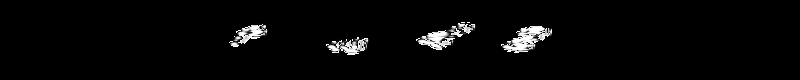

Epoch [2/10] Batch 115/121 Loss D: 1.2346, Loss G: 0.7794
Epoch [2/10] Batch 116/121 Loss D: 1.1366, Loss G: 0.7958
Epoch [2/10] Batch 117/121 Loss D: 1.2012, Loss G: 0.7629
Epoch [2/10] Batch 118/121 Loss D: 1.1577, Loss G: 0.8197
Epoch [2/10] Batch 119/121 Loss D: 1.2395, Loss G: 0.8156


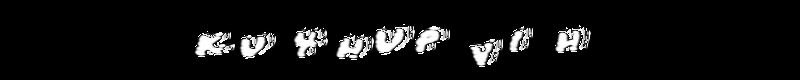

Epoch [2/10] Batch 120/121 Loss D: 1.1762, Loss G: 0.8388


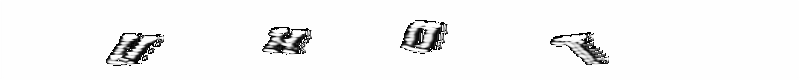

Epoch [3/10] Batch 0/121 Loss D: 1.0957, Loss G: 0.8909
Epoch [3/10] Batch 1/121 Loss D: 1.2665, Loss G: 0.7528
Epoch [3/10] Batch 2/121 Loss D: 1.2046, Loss G: 0.7753
Epoch [3/10] Batch 3/121 Loss D: 1.1589, Loss G: 0.8008
Epoch [3/10] Batch 4/121 Loss D: 1.2138, Loss G: 0.7823


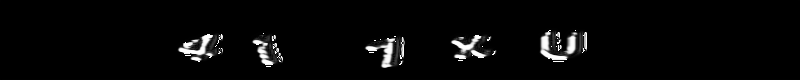

Epoch [3/10] Batch 5/121 Loss D: 1.2930, Loss G: 0.7366
Epoch [3/10] Batch 6/121 Loss D: 1.1776, Loss G: 0.7690
Epoch [3/10] Batch 7/121 Loss D: 1.2761, Loss G: 0.7100
Epoch [3/10] Batch 8/121 Loss D: 1.1258, Loss G: 0.8455
Epoch [3/10] Batch 9/121 Loss D: 1.1881, Loss G: 0.7990


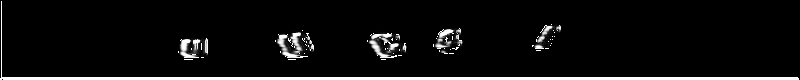

Epoch [3/10] Batch 10/121 Loss D: 1.2006, Loss G: 0.7694
Epoch [3/10] Batch 11/121 Loss D: 1.1985, Loss G: 0.8521
Epoch [3/10] Batch 12/121 Loss D: 1.2284, Loss G: 0.8066
Epoch [3/10] Batch 13/121 Loss D: 1.1879, Loss G: 0.7934
Epoch [3/10] Batch 14/121 Loss D: 1.1721, Loss G: 0.7520


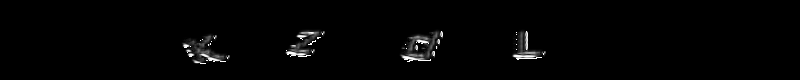

Epoch [3/10] Batch 15/121 Loss D: 1.2508, Loss G: 0.7705
Epoch [3/10] Batch 16/121 Loss D: 1.2564, Loss G: 0.7799
Epoch [3/10] Batch 17/121 Loss D: 1.1957, Loss G: 0.7401
Epoch [3/10] Batch 18/121 Loss D: 1.2425, Loss G: 0.7553
Epoch [3/10] Batch 19/121 Loss D: 1.1578, Loss G: 0.8209


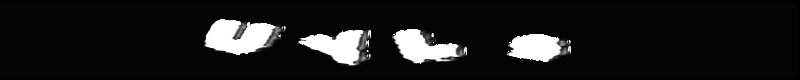

Epoch [3/10] Batch 20/121 Loss D: 1.2008, Loss G: 0.8746
Epoch [3/10] Batch 21/121 Loss D: 1.1898, Loss G: 0.8422
Epoch [3/10] Batch 22/121 Loss D: 1.1877, Loss G: 0.8088
Epoch [3/10] Batch 23/121 Loss D: 1.3110, Loss G: 0.8517
Epoch [3/10] Batch 24/121 Loss D: 1.1064, Loss G: 0.8794


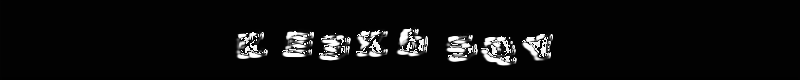

Epoch [3/10] Batch 25/121 Loss D: 1.1028, Loss G: 0.8671
Epoch [3/10] Batch 26/121 Loss D: 1.2214, Loss G: 0.7712
Epoch [3/10] Batch 27/121 Loss D: 1.2399, Loss G: 0.7536
Epoch [3/10] Batch 28/121 Loss D: 1.1761, Loss G: 0.8118
Epoch [3/10] Batch 29/121 Loss D: 1.1138, Loss G: 0.9057


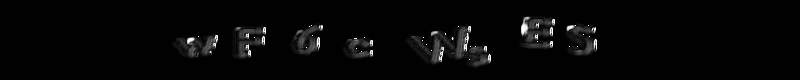

Epoch [3/10] Batch 30/121 Loss D: 1.1460, Loss G: 0.7462
Epoch [3/10] Batch 31/121 Loss D: 1.0810, Loss G: 0.8190
Epoch [3/10] Batch 32/121 Loss D: 0.8991, Loss G: 1.1481
Epoch [3/10] Batch 33/121 Loss D: 1.1459, Loss G: 0.9313
Epoch [3/10] Batch 34/121 Loss D: 1.1576, Loss G: 0.8267


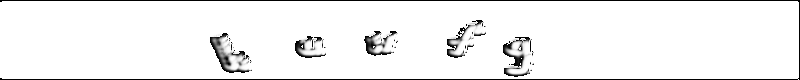

Epoch [3/10] Batch 35/121 Loss D: 1.2186, Loss G: 0.8703
Epoch [3/10] Batch 36/121 Loss D: 1.1684, Loss G: 0.9021
Epoch [3/10] Batch 37/121 Loss D: 1.2996, Loss G: 0.7968
Epoch [3/10] Batch 38/121 Loss D: 1.1171, Loss G: 0.8140
Epoch [3/10] Batch 39/121 Loss D: 1.1929, Loss G: 0.8323


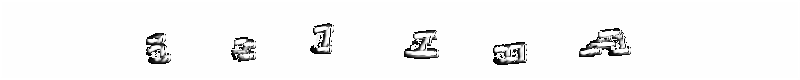

Epoch [3/10] Batch 40/121 Loss D: 1.1556, Loss G: 0.8346
Epoch [3/10] Batch 41/121 Loss D: 1.1262, Loss G: 0.7568
Epoch [3/10] Batch 42/121 Loss D: 1.1696, Loss G: 0.8598
Epoch [3/10] Batch 43/121 Loss D: 1.0983, Loss G: 0.9393
Epoch [3/10] Batch 44/121 Loss D: 1.0176, Loss G: 1.1234


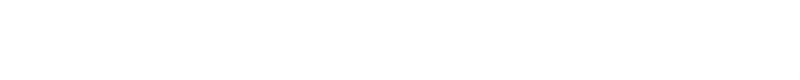

Epoch [3/10] Batch 45/121 Loss D: 0.7461, Loss G: 3.7847
Epoch [3/10] Batch 46/121 Loss D: 0.4425, Loss G: 3.8511
Epoch [3/10] Batch 47/121 Loss D: 0.4487, Loss G: 3.9267
Epoch [3/10] Batch 48/121 Loss D: 0.2287, Loss G: 4.0127
Epoch [3/10] Batch 49/121 Loss D: 0.1788, Loss G: 4.0959


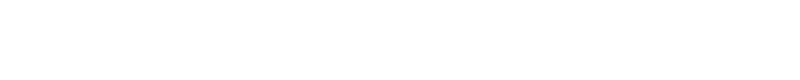

Epoch [3/10] Batch 50/121 Loss D: 0.1725, Loss G: 4.1719
Epoch [3/10] Batch 51/121 Loss D: 0.1754, Loss G: 4.2389
Epoch [3/10] Batch 52/121 Loss D: 0.1522, Loss G: 4.2993
Epoch [3/10] Batch 53/121 Loss D: 0.1213, Loss G: 4.3528
Epoch [3/10] Batch 54/121 Loss D: 0.1158, Loss G: 4.4028


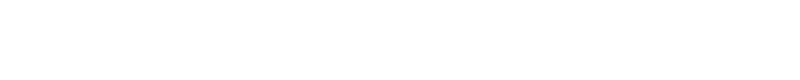

Epoch [3/10] Batch 55/121 Loss D: 0.1027, Loss G: 4.4489
Epoch [3/10] Batch 56/121 Loss D: 0.1214, Loss G: 4.4912
Epoch [3/10] Batch 57/121 Loss D: 0.1170, Loss G: 4.5296
Epoch [3/10] Batch 58/121 Loss D: 0.1182, Loss G: 4.5641
Epoch [3/10] Batch 59/121 Loss D: 0.0902, Loss G: 4.5977


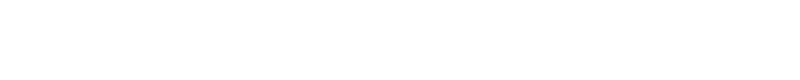

Epoch [3/10] Batch 60/121 Loss D: 0.0913, Loss G: 4.6296
Epoch [3/10] Batch 61/121 Loss D: 0.0843, Loss G: 4.6597
Epoch [3/10] Batch 62/121 Loss D: 0.0848, Loss G: 4.6878
Epoch [3/10] Batch 63/121 Loss D: 0.0896, Loss G: 4.7138
Epoch [3/10] Batch 64/121 Loss D: 0.0841, Loss G: 4.7403


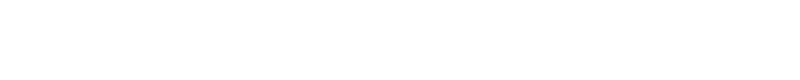

Epoch [3/10] Batch 65/121 Loss D: 0.0698, Loss G: 4.7661
Epoch [3/10] Batch 66/121 Loss D: 0.0756, Loss G: 4.7911
Epoch [3/10] Batch 67/121 Loss D: 0.0734, Loss G: 4.8147
Epoch [3/10] Batch 68/121 Loss D: 0.0847, Loss G: 4.8367
Epoch [3/10] Batch 69/121 Loss D: 0.0631, Loss G: 4.8587


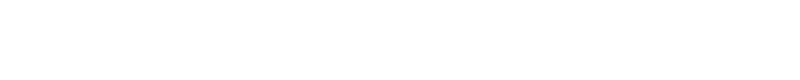

Epoch [3/10] Batch 70/121 Loss D: 0.0657, Loss G: 4.8799
Epoch [3/10] Batch 71/121 Loss D: 0.0663, Loss G: 4.9006
Epoch [3/10] Batch 72/121 Loss D: 0.0618, Loss G: 4.9209
Epoch [3/10] Batch 73/121 Loss D: 0.0583, Loss G: 4.9406
Epoch [3/10] Batch 74/121 Loss D: 0.0642, Loss G: 4.9592


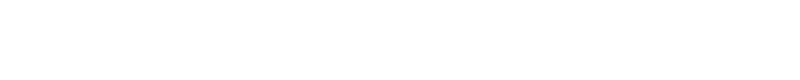

Epoch [3/10] Batch 75/121 Loss D: 0.0644, Loss G: 4.9768
Epoch [3/10] Batch 76/121 Loss D: 0.0546, Loss G: 4.9944
Epoch [3/10] Batch 77/121 Loss D: 0.0576, Loss G: 5.0114
Epoch [3/10] Batch 78/121 Loss D: 0.0508, Loss G: 5.0287
Epoch [3/10] Batch 79/121 Loss D: 0.0486, Loss G: 5.0455


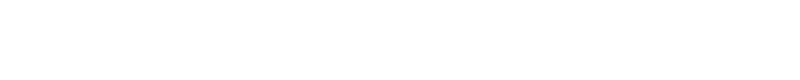

Epoch [3/10] Batch 80/121 Loss D: 0.0574, Loss G: 5.0618
Epoch [3/10] Batch 81/121 Loss D: 0.0518, Loss G: 5.0782
Epoch [3/10] Batch 82/121 Loss D: 0.0516, Loss G: 5.0946
Epoch [3/10] Batch 83/121 Loss D: 0.0477, Loss G: 5.1102
Epoch [3/10] Batch 84/121 Loss D: 0.0425, Loss G: 5.1268


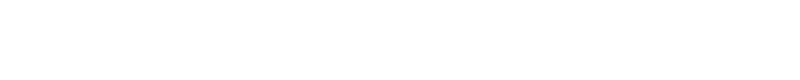

Epoch [3/10] Batch 85/121 Loss D: 0.0528, Loss G: 5.1418
Epoch [3/10] Batch 86/121 Loss D: 0.0434, Loss G: 5.1568
Epoch [3/10] Batch 87/121 Loss D: 0.0511, Loss G: 5.1714
Epoch [3/10] Batch 88/121 Loss D: 0.0523, Loss G: 5.1854
Epoch [3/10] Batch 89/121 Loss D: 0.0508, Loss G: 5.1986


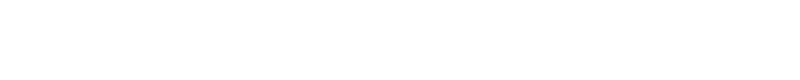

Epoch [3/10] Batch 90/121 Loss D: 0.0489, Loss G: 5.2122
Epoch [3/10] Batch 91/121 Loss D: 0.0468, Loss G: 5.2252
Epoch [3/10] Batch 92/121 Loss D: 0.0513, Loss G: 5.2369
Epoch [3/10] Batch 93/121 Loss D: 0.0455, Loss G: 5.2499
Epoch [3/10] Batch 94/121 Loss D: 0.0370, Loss G: 5.2622


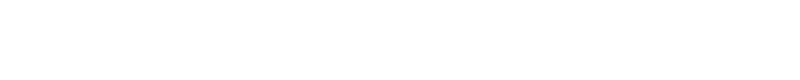

Epoch [3/10] Batch 95/121 Loss D: 0.0408, Loss G: 5.2740
Epoch [3/10] Batch 96/121 Loss D: 0.0395, Loss G: 5.2864
Epoch [3/10] Batch 97/121 Loss D: 0.0391, Loss G: 5.2979
Epoch [3/10] Batch 98/121 Loss D: 0.0349, Loss G: 5.3105
Epoch [3/10] Batch 99/121 Loss D: 0.0415, Loss G: 5.3230


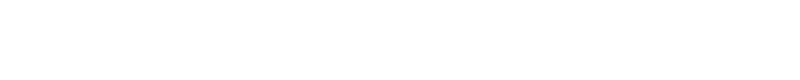

Epoch [3/10] Batch 100/121 Loss D: 0.0353, Loss G: 5.3359
Epoch [3/10] Batch 101/121 Loss D: 0.0383, Loss G: 5.3476
Epoch [3/10] Batch 102/121 Loss D: 0.0427, Loss G: 5.3589
Epoch [3/10] Batch 103/121 Loss D: 0.0423, Loss G: 5.3696
Epoch [3/10] Batch 104/121 Loss D: 0.0348, Loss G: 5.3796


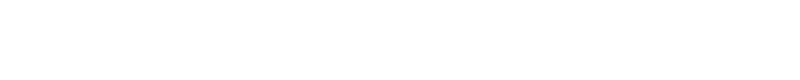

Epoch [3/10] Batch 105/121 Loss D: 0.0377, Loss G: 5.3906
Epoch [3/10] Batch 106/121 Loss D: 0.0417, Loss G: 5.4001
Epoch [3/10] Batch 107/121 Loss D: 0.0354, Loss G: 5.4101
Epoch [3/10] Batch 108/121 Loss D: 0.0327, Loss G: 5.4201
Epoch [3/10] Batch 109/121 Loss D: 0.0313, Loss G: 5.4302


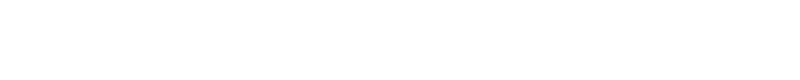

Epoch [3/10] Batch 110/121 Loss D: 0.0299, Loss G: 5.4396
Epoch [3/10] Batch 111/121 Loss D: 0.0304, Loss G: 5.4492
Epoch [3/10] Batch 112/121 Loss D: 0.0273, Loss G: 5.4588
Epoch [3/10] Batch 113/121 Loss D: 0.0287, Loss G: 5.4676
Epoch [3/10] Batch 114/121 Loss D: 0.0324, Loss G: 5.4767


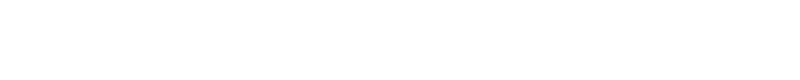

Epoch [3/10] Batch 115/121 Loss D: 0.0308, Loss G: 5.4855
Epoch [3/10] Batch 116/121 Loss D: 0.0340, Loss G: 5.4935
Epoch [3/10] Batch 117/121 Loss D: 0.0295, Loss G: 5.5016
Epoch [3/10] Batch 118/121 Loss D: 0.0349, Loss G: 5.5095
Epoch [3/10] Batch 119/121 Loss D: 0.0369, Loss G: 5.5169


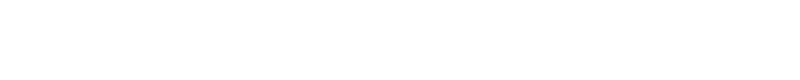

Epoch [3/10] Batch 120/121 Loss D: 0.0282, Loss G: 5.5248


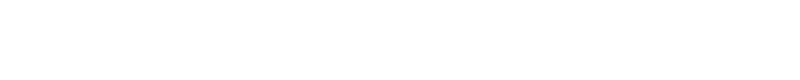

Epoch [4/10] Batch 0/121 Loss D: 0.0311, Loss G: 5.5322
Epoch [4/10] Batch 1/121 Loss D: 0.0263, Loss G: 5.5403
Epoch [4/10] Batch 2/121 Loss D: 0.0314, Loss G: 5.5479
Epoch [4/10] Batch 3/121 Loss D: 0.0261, Loss G: 5.5554
Epoch [4/10] Batch 4/121 Loss D: 0.0288, Loss G: 5.5623


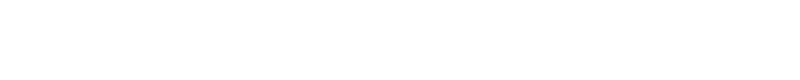

Epoch [4/10] Batch 5/121 Loss D: 0.0272, Loss G: 5.5696
Epoch [4/10] Batch 6/121 Loss D: 0.0274, Loss G: 5.5767
Epoch [4/10] Batch 7/121 Loss D: 0.0290, Loss G: 5.5839
Epoch [4/10] Batch 8/121 Loss D: 0.0268, Loss G: 5.5908
Epoch [4/10] Batch 9/121 Loss D: 0.0271, Loss G: 5.5978


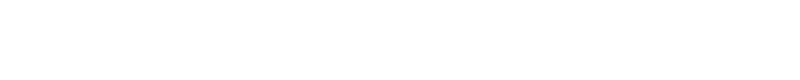

Epoch [4/10] Batch 10/121 Loss D: 0.0307, Loss G: 5.6045
Epoch [4/10] Batch 11/121 Loss D: 0.0239, Loss G: 5.6115
Epoch [4/10] Batch 12/121 Loss D: 0.0273, Loss G: 5.6180
Epoch [4/10] Batch 13/121 Loss D: 0.0308, Loss G: 5.6249
Epoch [4/10] Batch 14/121 Loss D: 0.0279, Loss G: 5.6315


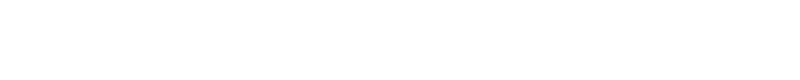

Epoch [4/10] Batch 15/121 Loss D: 0.0269, Loss G: 5.6379
Epoch [4/10] Batch 16/121 Loss D: 0.0293, Loss G: 5.6444
Epoch [4/10] Batch 17/121 Loss D: 0.0275, Loss G: 5.6509
Epoch [4/10] Batch 18/121 Loss D: 0.0235, Loss G: 5.6575
Epoch [4/10] Batch 19/121 Loss D: 0.0246, Loss G: 5.6642


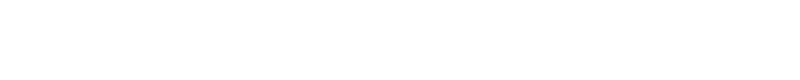

Epoch [4/10] Batch 20/121 Loss D: 0.0254, Loss G: 5.6706
Epoch [4/10] Batch 21/121 Loss D: 0.0221, Loss G: 5.6776
Epoch [4/10] Batch 22/121 Loss D: 0.0263, Loss G: 5.6841
Epoch [4/10] Batch 23/121 Loss D: 0.0242, Loss G: 5.6906
Epoch [4/10] Batch 24/121 Loss D: 0.0275, Loss G: 5.6971


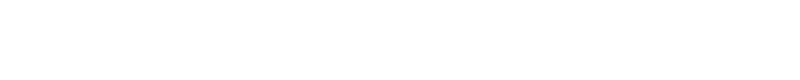

Epoch [4/10] Batch 25/121 Loss D: 0.0202, Loss G: 5.7038
Epoch [4/10] Batch 26/121 Loss D: 0.0220, Loss G: 5.7105
Epoch [4/10] Batch 27/121 Loss D: 0.0261, Loss G: 5.7175
Epoch [4/10] Batch 28/121 Loss D: 0.0234, Loss G: 5.7231
Epoch [4/10] Batch 29/121 Loss D: 0.0213, Loss G: 5.7291


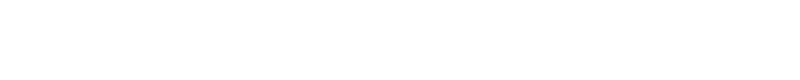

Epoch [4/10] Batch 30/121 Loss D: 0.0193, Loss G: 5.7350
Epoch [4/10] Batch 31/121 Loss D: 0.0206, Loss G: 5.7410
Epoch [4/10] Batch 32/121 Loss D: 0.0228, Loss G: 5.7465
Epoch [4/10] Batch 33/121 Loss D: 0.0218, Loss G: 5.7522
Epoch [4/10] Batch 34/121 Loss D: 0.0205, Loss G: 5.7582


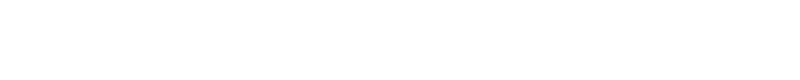

Epoch [4/10] Batch 35/121 Loss D: 0.0204, Loss G: 5.7636
Epoch [4/10] Batch 36/121 Loss D: 0.0240, Loss G: 5.7693
Epoch [4/10] Batch 37/121 Loss D: 0.0182, Loss G: 5.7746
Epoch [4/10] Batch 38/121 Loss D: 0.0184, Loss G: 5.7809
Epoch [4/10] Batch 39/121 Loss D: 0.0238, Loss G: 5.7861


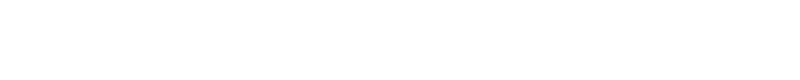

Epoch [4/10] Batch 40/121 Loss D: 0.0218, Loss G: 5.7914
Epoch [4/10] Batch 41/121 Loss D: 0.0247, Loss G: 5.7968
Epoch [4/10] Batch 42/121 Loss D: 0.0210, Loss G: 5.8014
Epoch [4/10] Batch 43/121 Loss D: 0.0276, Loss G: 5.8067
Epoch [4/10] Batch 44/121 Loss D: 0.0192, Loss G: 5.8115


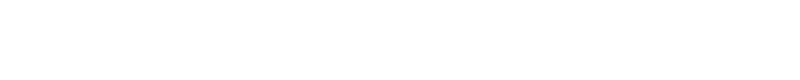

Epoch [4/10] Batch 45/121 Loss D: 0.0225, Loss G: 5.8169
Epoch [4/10] Batch 46/121 Loss D: 0.0196, Loss G: 5.8213
Epoch [4/10] Batch 47/121 Loss D: 0.0197, Loss G: 5.8271
Epoch [4/10] Batch 48/121 Loss D: 0.0221, Loss G: 5.8315
Epoch [4/10] Batch 49/121 Loss D: 0.0181, Loss G: 5.8361


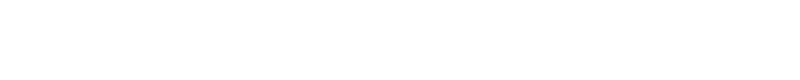

Epoch [4/10] Batch 50/121 Loss D: 0.0175, Loss G: 5.8420
Epoch [4/10] Batch 51/121 Loss D: 0.0248, Loss G: 5.8470
Epoch [4/10] Batch 52/121 Loss D: 0.0166, Loss G: 5.8519
Epoch [4/10] Batch 53/121 Loss D: 0.0187, Loss G: 5.8567
Epoch [4/10] Batch 54/121 Loss D: 0.0222, Loss G: 5.8614


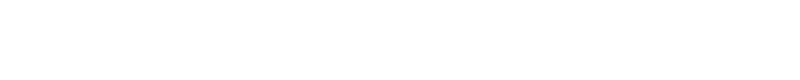

Epoch [4/10] Batch 55/121 Loss D: 0.0189, Loss G: 5.8661
Epoch [4/10] Batch 56/121 Loss D: 0.0188, Loss G: 5.8705
Epoch [4/10] Batch 57/121 Loss D: 0.0209, Loss G: 5.8753
Epoch [4/10] Batch 58/121 Loss D: 0.0167, Loss G: 5.8798
Epoch [4/10] Batch 59/121 Loss D: 0.0188, Loss G: 5.8851


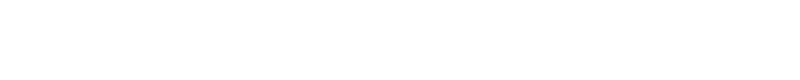

Epoch [4/10] Batch 60/121 Loss D: 0.0139, Loss G: 5.8893
Epoch [4/10] Batch 61/121 Loss D: 0.0194, Loss G: 5.8942
Epoch [4/10] Batch 62/121 Loss D: 0.0203, Loss G: 5.8989
Epoch [4/10] Batch 63/121 Loss D: 0.0162, Loss G: 5.9035
Epoch [4/10] Batch 64/121 Loss D: 0.0174, Loss G: 5.9079


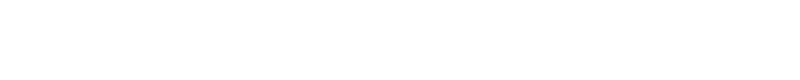

Epoch [4/10] Batch 65/121 Loss D: 0.0194, Loss G: 5.9118
Epoch [4/10] Batch 66/121 Loss D: 0.0207, Loss G: 5.9167
Epoch [4/10] Batch 67/121 Loss D: 0.0182, Loss G: 5.9210
Epoch [4/10] Batch 68/121 Loss D: 0.0171, Loss G: 5.9256
Epoch [4/10] Batch 69/121 Loss D: 0.0170, Loss G: 5.9299


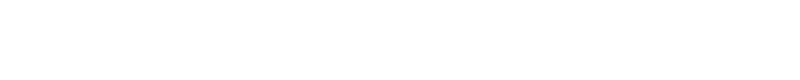

Epoch [4/10] Batch 70/121 Loss D: 0.0172, Loss G: 5.9340
Epoch [4/10] Batch 71/121 Loss D: 0.0166, Loss G: 5.9385
Epoch [4/10] Batch 72/121 Loss D: 0.0185, Loss G: 5.9429
Epoch [4/10] Batch 73/121 Loss D: 0.0175, Loss G: 5.9463
Epoch [4/10] Batch 74/121 Loss D: 0.0156, Loss G: 5.9511


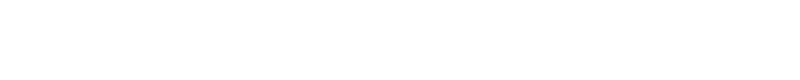

Epoch [4/10] Batch 75/121 Loss D: 0.0157, Loss G: 5.9551
Epoch [4/10] Batch 76/121 Loss D: 0.0153, Loss G: 5.9594
Epoch [4/10] Batch 77/121 Loss D: 0.0173, Loss G: 5.9638
Epoch [4/10] Batch 78/121 Loss D: 0.0150, Loss G: 5.9675
Epoch [4/10] Batch 79/121 Loss D: 0.0157, Loss G: 5.9715


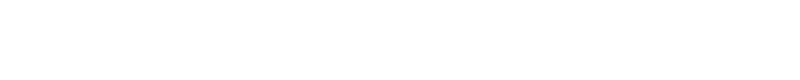

Epoch [4/10] Batch 80/121 Loss D: 0.0136, Loss G: 5.9760
Epoch [4/10] Batch 81/121 Loss D: 0.0142, Loss G: 5.9803
Epoch [4/10] Batch 82/121 Loss D: 0.0156, Loss G: 5.9842
Epoch [4/10] Batch 83/121 Loss D: 0.0149, Loss G: 5.9880
Epoch [4/10] Batch 84/121 Loss D: 0.0169, Loss G: 5.9923


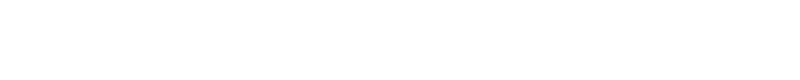

Epoch [4/10] Batch 85/121 Loss D: 0.0139, Loss G: 5.9966
Epoch [4/10] Batch 86/121 Loss D: 0.0174, Loss G: 6.0006
Epoch [4/10] Batch 87/121 Loss D: 0.0175, Loss G: 6.0045
Epoch [4/10] Batch 88/121 Loss D: 0.0159, Loss G: 6.0088
Epoch [4/10] Batch 89/121 Loss D: 0.0158, Loss G: 6.0126


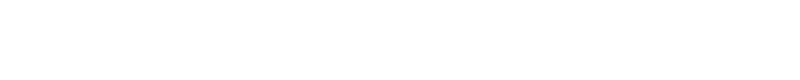

Epoch [4/10] Batch 90/121 Loss D: 0.0157, Loss G: 6.0163
Epoch [4/10] Batch 91/121 Loss D: 0.0189, Loss G: 6.0203
Epoch [4/10] Batch 92/121 Loss D: 0.0153, Loss G: 6.0239
Epoch [4/10] Batch 93/121 Loss D: 0.0153, Loss G: 6.0282
Epoch [4/10] Batch 94/121 Loss D: 0.0147, Loss G: 6.0315


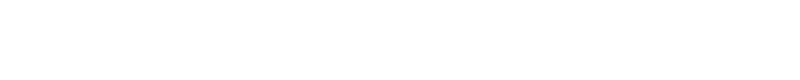

Epoch [4/10] Batch 95/121 Loss D: 0.0153, Loss G: 6.0358
Epoch [4/10] Batch 96/121 Loss D: 0.0142, Loss G: 6.0402
Epoch [4/10] Batch 97/121 Loss D: 0.0154, Loss G: 6.0435
Epoch [4/10] Batch 98/121 Loss D: 0.0143, Loss G: 6.0475
Epoch [4/10] Batch 99/121 Loss D: 0.0124, Loss G: 6.0509


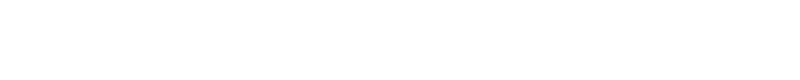

Epoch [4/10] Batch 100/121 Loss D: 0.0137, Loss G: 6.0554
Epoch [4/10] Batch 101/121 Loss D: 0.0109, Loss G: 6.0592
Epoch [4/10] Batch 102/121 Loss D: 0.0147, Loss G: 6.0628
Epoch [4/10] Batch 103/121 Loss D: 0.0157, Loss G: 6.0664
Epoch [4/10] Batch 104/121 Loss D: 0.0149, Loss G: 6.0703


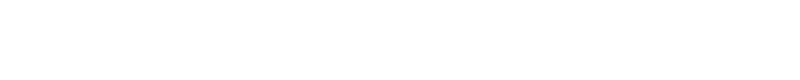

Epoch [4/10] Batch 105/121 Loss D: 0.0113, Loss G: 6.0745
Epoch [4/10] Batch 106/121 Loss D: 0.0132, Loss G: 6.0784
Epoch [4/10] Batch 107/121 Loss D: 0.0146, Loss G: 6.0818
Epoch [4/10] Batch 108/121 Loss D: 0.0140, Loss G: 6.0860
Epoch [4/10] Batch 109/121 Loss D: 0.0146, Loss G: 6.0891


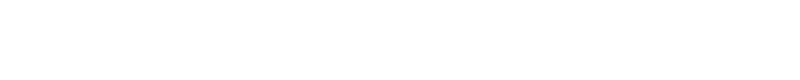

Epoch [4/10] Batch 110/121 Loss D: 0.0154, Loss G: 6.0927
Epoch [4/10] Batch 111/121 Loss D: 0.0104, Loss G: 6.0964
Epoch [4/10] Batch 112/121 Loss D: 0.0118, Loss G: 6.0995
Epoch [4/10] Batch 113/121 Loss D: 0.0138, Loss G: 6.1036
Epoch [4/10] Batch 114/121 Loss D: 0.0140, Loss G: 6.1070


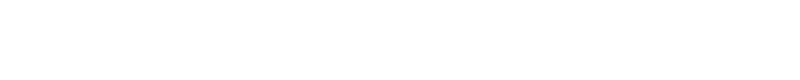

Epoch [4/10] Batch 115/121 Loss D: 0.0136, Loss G: 6.1106
Epoch [4/10] Batch 116/121 Loss D: 0.0127, Loss G: 6.1138
Epoch [4/10] Batch 117/121 Loss D: 0.0118, Loss G: 6.1179
Epoch [4/10] Batch 118/121 Loss D: 0.0137, Loss G: 6.1216
Epoch [4/10] Batch 119/121 Loss D: 0.0103, Loss G: 6.1244


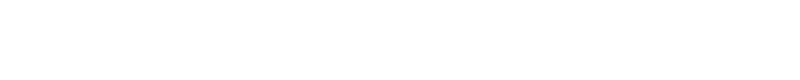

Epoch [4/10] Batch 120/121 Loss D: 0.0126, Loss G: 6.1282


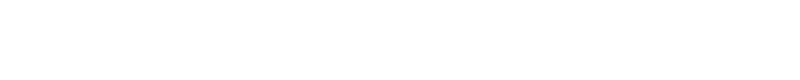

Epoch [5/10] Batch 0/121 Loss D: 0.0111, Loss G: 6.1316
Epoch [5/10] Batch 1/121 Loss D: 0.0120, Loss G: 6.1356
Epoch [5/10] Batch 2/121 Loss D: 0.0141, Loss G: 6.1389
Epoch [5/10] Batch 3/121 Loss D: 0.0152, Loss G: 6.1419
Epoch [5/10] Batch 4/121 Loss D: 0.0127, Loss G: 6.1456


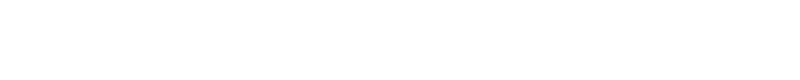

Epoch [5/10] Batch 5/121 Loss D: 0.0116, Loss G: 6.1485
Epoch [5/10] Batch 6/121 Loss D: 0.0116, Loss G: 6.1523
Epoch [5/10] Batch 7/121 Loss D: 0.0128, Loss G: 6.1556
Epoch [5/10] Batch 8/121 Loss D: 0.0122, Loss G: 6.1591
Epoch [5/10] Batch 9/121 Loss D: 0.0129, Loss G: 6.1621


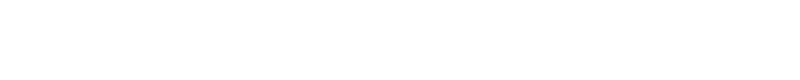

Epoch [5/10] Batch 10/121 Loss D: 0.0123, Loss G: 6.1656
Epoch [5/10] Batch 11/121 Loss D: 0.0113, Loss G: 6.1687
Epoch [5/10] Batch 12/121 Loss D: 0.0145, Loss G: 6.1721
Epoch [5/10] Batch 13/121 Loss D: 0.0129, Loss G: 6.1751
Epoch [5/10] Batch 14/121 Loss D: 0.0134, Loss G: 6.1783


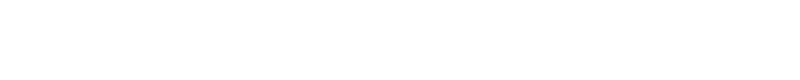

Epoch [5/10] Batch 15/121 Loss D: 0.0109, Loss G: 6.1814
Epoch [5/10] Batch 16/121 Loss D: 0.0121, Loss G: 6.1847
Epoch [5/10] Batch 17/121 Loss D: 0.0137, Loss G: 6.1878
Epoch [5/10] Batch 18/121 Loss D: 0.0122, Loss G: 6.1906
Epoch [5/10] Batch 19/121 Loss D: 0.0134, Loss G: 6.1939


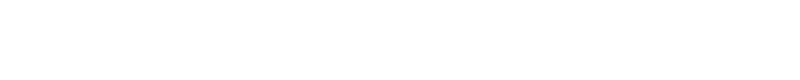

Epoch [5/10] Batch 20/121 Loss D: 0.0116, Loss G: 6.1968
Epoch [5/10] Batch 21/121 Loss D: 0.0109, Loss G: 6.2002
Epoch [5/10] Batch 22/121 Loss D: 0.0112, Loss G: 6.2033
Epoch [5/10] Batch 23/121 Loss D: 0.0111, Loss G: 6.2063
Epoch [5/10] Batch 24/121 Loss D: 0.0119, Loss G: 6.2094


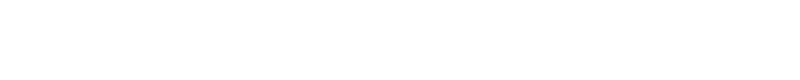

Epoch [5/10] Batch 25/121 Loss D: 0.0124, Loss G: 6.2127
Epoch [5/10] Batch 26/121 Loss D: 0.0114, Loss G: 6.2156
Epoch [5/10] Batch 27/121 Loss D: 0.0129, Loss G: 6.2186
Epoch [5/10] Batch 28/121 Loss D: 0.0122, Loss G: 6.2213
Epoch [5/10] Batch 29/121 Loss D: 0.0126, Loss G: 6.2244


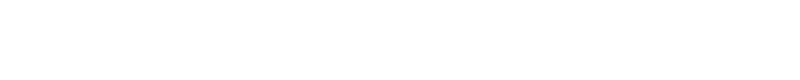

Epoch [5/10] Batch 30/121 Loss D: 0.0123, Loss G: 6.2272
Epoch [5/10] Batch 31/121 Loss D: 0.0105, Loss G: 6.2301
Epoch [5/10] Batch 32/121 Loss D: 0.0132, Loss G: 6.2330
Epoch [5/10] Batch 33/121 Loss D: 0.0116, Loss G: 6.2358
Epoch [5/10] Batch 34/121 Loss D: 0.0112, Loss G: 6.2388


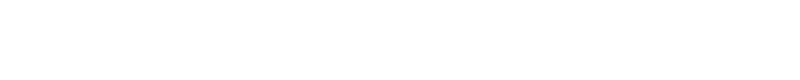

Epoch [5/10] Batch 35/121 Loss D: 0.0119, Loss G: 6.2416
Epoch [5/10] Batch 36/121 Loss D: 0.0111, Loss G: 6.2446
Epoch [5/10] Batch 37/121 Loss D: 0.0104, Loss G: 6.2475
Epoch [5/10] Batch 38/121 Loss D: 0.0122, Loss G: 6.2504
Epoch [5/10] Batch 39/121 Loss D: 0.0114, Loss G: 6.2533


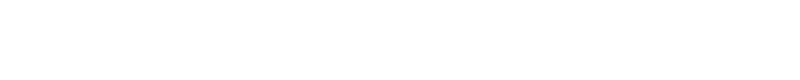

Epoch [5/10] Batch 40/121 Loss D: 0.0111, Loss G: 6.2562
Epoch [5/10] Batch 41/121 Loss D: 0.0139, Loss G: 6.2587
Epoch [5/10] Batch 42/121 Loss D: 0.0105, Loss G: 6.2619
Epoch [5/10] Batch 43/121 Loss D: 0.0081, Loss G: 6.2647
Epoch [5/10] Batch 44/121 Loss D: 0.0092, Loss G: 6.2678


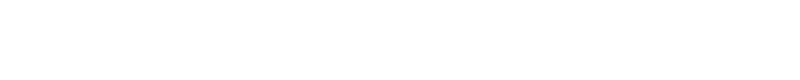

KeyboardInterrupt: 

In [ ]:
for epoch in range(num_epochs):
    for i, images in enumerate(dataloader):
        real_imgs = images.to(device)
        b_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(b_size, 1, device=device)
        fake_labels = torch.zeros(b_size, 1, device=device)

        # ---- Train Discriminator ----
        netD.zero_grad()

        # Real images
        output_real = netD(real_imgs).view(-1, 1)
        lossD_real = criterion(output_real, real_labels)

        # Fake images
        fake_imgs = [transform(generate_random_captcha()) for _ in range(b_size)]
        fake_imgs = torch.stack(fake_imgs).reshape(b_size, 1, 80, 800).to(device)
        fake_imgs = netG(fake_imgs) # go through generator to apply pixel-level adjustments
        if not i % 5:
            display(Image.fromarray((fake_imgs[0].cpu().detach().numpy().reshape(80, 800) * 255).astype(np.uint8)))
        output_fake = netD(fake_imgs.detach()).view(-1, 1)
        lossD_fake = criterion(output_fake, fake_labels)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # ---- Train Generator ----
        netG.zero_grad()

        # Try to fool the discriminator
        output_fake_for_G = netD(fake_imgs).view(-1, 1)
        lossG = criterion(output_fake_for_G, real_labels)
        lossG.backward()
        optimizerG.step()

        if i % 1 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} "
                  f"Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")